### FCNN Model Loop with Skill Score calculation

File recreated on 6/26/2025 for the "updated" model. 

I will start with a 14 day model. 

I added in the LRP too.

In [1]:
##import cell makes its appearance once again...
%matplotlib inline
##so-called "math" related imports
#from netCDF4 import Dataset as ncread
import numpy as np
import pandas as pd
import math
import random
from random import seed
from random import randint
from random import sample
from scipy.ndimage import gaussian_filter
from sklearn.metrics import brier_score_loss
from sklearn.model_selection import TimeSeriesSplit
import xarray as xr

import pickle

import warnings
warnings.filterwarnings("ignore")

##plotting related imports
import matplotlib.pyplot as plt

#import tensorflow/keras related files
import tensorflow as tf    
#tf.compat.v1.disable_v2_behavior() # <-- HERE !

tf.device('/physical_device:GPU:0')

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import regularizers
import tensorflow.keras.backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dropout, Activation, Reshape, Flatten, LSTM, Dense, Dropout, Embedding, Bidirectional, GRU, Concatenate
from tensorflow.keras import Sequential
from tensorflow.keras import initializers, regularizers
from tensorflow.keras import optimizers
from tensorflow.keras import constraints
from tensorflow.keras.layers import Layer, InputSpec

import shap
import pylab
tf.compat.v1.disable_eager_execution()
import investigate
import innvestigate

2025-06-27 00:56:42.922984: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-27 00:56:42.924960: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-27 00:56:42.951556: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-27 00:56:42.951577: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-27 00:56:42.951596: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

In [2]:
from StatScores import BSS
from StatScores import RAS
from StatScores import PAS

### Inputs.

In [3]:
##load in solvers for PC analysis to get the PCs for the model itself. 

In [4]:
#load input data
infile = open("../eof_data/vertanom_u.p","rb",)
u_input = pickle.load(infile)  ##vertical U cross section
#flat_u_14 = u_input[:62, 19:168, :, :].reshape((62 * 149, 37, 36))
infile.close()

infile = open("../eof_data/vertanom_ehf.p","rb",)
ehf_input = pickle.load(infile)  ##ZMehf vertical cross section along longitudes
#flat_EHF_14 = ehf_input[:62, 19:168, :, :].reshape((62 * 149, 37, 180))
infile.close()

infile = open("../eof_data/vertanom_gph.p","rb",)
gph_input = pickle.load(infile)  ##GPH vertical cross section along longitudes
#flat_GPH_14= gph_input[:62, 19:168, :, :].reshape((62 * 149, 37, 180))
infile.close()

##19:168 for 14 days and 
##19:162 for 20 days and 
##19:152 for 30 days. 

u_14 = u_input[:62, 19:168, :, :]
EHF_14 = ehf_input[:62, 19:168, :, :]
GPH_14= gph_input[:62, 19:168, :, :]

print("U Wind shape: ",u_14.shape)
print("EHF shape: ",EHF_14.shape)
print("GPH shape: ",GPH_14.shape)

U Wind shape:  (62, 149, 37, 36)
EHF shape:  (62, 149, 37, 180)
GPH shape:  (62, 149, 37, 180)


### Outputs. 

In [5]:
# load output data
# 149 for 14
# 143 for 20 and 
# 133 for 30 

infile = open("../reduced_data/temps/eur_14.p","rb",)
output = pickle.load(infile) 
output = output.reshape(62, 149)
infile.close()

In [6]:
# load climo data
infile = open("../reduced_data/climo/eur_climo14.p","rb",)
climo = pickle.load(infile) 
infile.close()

In [7]:
lead = 149

temp = output[:,:]
print(temp.shape)

climo = climo.reshape(62, 149, 2)
climo = climo[:, :, :]
#climo = climo.reshape(8370,2)

print("climo: ",climo.shape)
print("output: ",temp.shape)

(62, 149)
climo:  (62, 149, 2)
output:  (62, 149)


In [8]:
#this can be commented out if not needed. 
input_u =  u_14
input_ehf =  EHF_14
input_gph =  GPH_14
temp_n = temp
new_climo = climo.reshape(62*149,2)

In [9]:
frac_ind = round((62*lead)*0.15)
frac_end = round((62*lead)-frac_ind)

print("testing and validation size: ",frac_ind)
print("training size: ",frac_end)

testing and validation size:  1386
training size:  7852


In [10]:
##Set X_all and Y_all datasets
X_all1 = np.copy(input_u.reshape(62*lead,37*36)) ##u
X_all2 = np.copy(input_ehf.reshape(62*lead,37*180)) ##ehf
X_all3 = np.copy(input_gph.reshape(62*lead,37*180)) ##gph

Y_all = np.copy(temp_n.reshape(62*lead))

##training data partition out
X_tri1 = X_all1[:frac_end,:] ##u
X_tri2 = X_all2[:frac_end,:] ##ehf
X_tri3 = X_all3[:frac_end,:] ##gph

Y_tri = Y_all[:frac_end]

#testing data partition out
X_tes1 = X_all1[frac_end:,:]
X_tes2 = X_all2[frac_end:,:]
X_tes3 = X_all3[frac_end:,:]

Y_tes = Y_all[frac_end:]

#Convert the Y array into a categorical array. This means we will create one-hot vector labels for all of the inputs.
# The one-hot vectors have an index for each possible output category (two in our case)
# A "1" is put in the index corresponding to the category to which the sample belongs
Y_all = keras.utils.to_categorical(Y_all)
Y_tri = keras.utils.to_categorical(Y_tri)
Y_tes= keras.utils.to_categorical(Y_tes)

In [11]:
##checking my data for NaN of Infs because I need to make sure this doesn't cause
#the model to throw back no loss

if np.any(np.isnan(X_all1)) or np.any(np.isinf(X_all1)):
    print("NaN or Inf values found in X_all!")

if np.any(np.isnan(Y_all)) or np.any(np.isinf(Y_all)):
    print("NaN or Inf values found in Y_all!")

### Begin establishing specifics of model.

In [12]:
##number of input nodes
input_shape1=  X_all1.shape[-1] # u
input_shape2= X_all2.shape[-1] ## ehf
input_shape3= X_all3.shape[-1] ## gph

print(input_shape1)
print(input_shape2)
print(input_shape3)

1332
6660
6660


In [13]:
########
#CHANGE BASED ON NUMBER OF FOLDS FOR TIMESERIES SPLIT
n = 100

In [14]:
##class weight creator for the instance where now I have a four dimensional output array 
def class_weight_creator(Y):
    class_dict = {}
    Y_reshaped = Y.reshape(-1, Y.shape[-1])
    weights = np.max(np.sum(Y_reshaped, axis=0)) / np.sum(Y_reshaped, axis=0)
    for i in range(Y.shape[-1] ):
        class_dict[i] = weights[i]
        
    return class_dict

In [15]:
##definition statement for ACC
def calculate_accuracy(y_true, y_prob, threshold=0.5):
    y_pred = (y_prob >= threshold).astype(int)
    return np.mean(y_true == y_pred)

In [16]:
##Loss and ACC lists, only relevant w/o early stopping
train_loss = []
val_loss = []
cat_acc = []
val_acc = [] 

##BSS Arrays, all of the skill scores have 200 rows
#because that is how many cross-validations I will do for the model
BSS_all= np.empty((n,))
BSS_val= np.empty((n,))
BSS_train= np.empty((n,))
BSS_test= np.empty((n,))
BSS_90= np.empty((n,))

BSS_avg= np.empty((n,))
BSS_30= np.empty((n,))
BSS_70= np.empty((n,))

##RAS and PAS Arrays
Prec_all= np.empty((n,2))
Rec_all= np.empty((n,2))

Prec_val= np.empty((n,2))
Rec_val= np.empty((n,2))

Prec_train= np.empty((n,2))
Rec_train= np.empty((n,2))

Prec_test= np.empty((n,2))
Rec_test= np.empty((n,2))


In [17]:
##empty lists for ACC scores 
##Testing Accuracy Arrays
fulltest_acc = []
test90_acc = []

##Training Accuracy Arrays
fulltrain_acc = []
train90_acc = []

##Validation Accuracy Arrays
fullval_acc = []
val90_acc = []

In [18]:
##probabilities
p_test = []
p_train = []
p_val = []

p_mid = []
p_90 = []
p_30 = []
p_70 = []

##correct positive
posXtest = []
#false positive
FposXtest = []
#correct negative
negXtest = []
#false negative
FnegXtest = []

index90 = []
indexmin = []
indexmid = []
indexmax = []

##correct positive
percpos = []
#false positive
percFpos = []
#correct negative
percneg = []
#false negative
percFneg = []

In [19]:
##LRP
U_comp_pos  = np.zeros((n, 1332))
U_comp_neg  = np.zeros((n, 1332))
U_comp_Fpos = np.zeros((n, 1332))
U_comp_Fneg = np.zeros((n, 1332))

EHF_comp_pos  = np.zeros((n, 6660))
EHF_comp_neg  = np.zeros((n, 6660))
EHF_comp_Fpos = np.zeros((n, 6660))
EHF_comp_Fneg = np.zeros((n, 6660))

GPH_comp_pos  = np.zeros((n, 6660))
GPH_comp_neg  = np.zeros((n, 6660))
GPH_comp_Fpos = np.zeros((n, 6660))
GPH_comp_Fneg = np.zeros((n, 6660))

U_pos90_LRP   = np.zeros((n, 37, 36))
EHF_pos90_LRP = np.zeros((n, 37, 180))
GPH_pos90_LRP = np.zeros((n, 37, 180))

U_Fpos90_LRP   = np.zeros((n, 37, 36))
EHF_Fpos90_LRP = np.zeros((n, 37, 180))
GPH_Fpos90_LRP = np.zeros((n, 37, 180))

U_Fneg90_LRP   = np.zeros((n, 37, 36))
EHF_Fneg90_LRP = np.zeros((n, 37, 180))
GPH_Fneg90_LRP = np.zeros((n, 37, 180))

U_neg90_LRP   = np.zeros((n, 37, 36))
EHF_neg90_LRP = np.zeros((n, 37, 180))
GPH_neg90_LRP = np.zeros((n, 37, 180))

### Model Architecture. 

In [20]:
def train_datasubset(data,start,end):
    train1 = data[0:start]
    train2 = data[end:]
    train = np.concatenate((train1,train2))
    return train;

In [21]:
##giant LRP loop lol
def run_lrp_analysis_3features(
    model, X_test,
    correct_pos, correct_neg, false_pos, false_neg,
    X_tes1, X_tes2, X_tes3,  # Uwind, EHF, GPH (all flattened)
    l,  #loop index

    #arrays for composites (flattened)
    U_comp_pos,   U_comp_neg,   U_comp_Fpos,   U_comp_Fneg,
    EHF_comp_pos, EHF_comp_neg, EHF_comp_Fpos, EHF_comp_Fneg,
    GPH_comp_pos, GPH_comp_neg, GPH_comp_Fpos, GPH_comp_Fneg,

    #arrays for LRP heatmaps (reshaped)
    U_pos90_LRP,   U_neg90_LRP,   U_Fpos90_LRP,   U_Fneg90_LRP,
    EHF_pos90_LRP, EHF_neg90_LRP, EHF_Fpos90_LRP, EHF_Fneg90_LRP,
    GPH_pos90_LRP, GPH_neg90_LRP, GPH_Fpos90_LRP, GPH_Fneg90_LRP
):
    def process_subset(analysis_data, mask, X_tensor, comp_arr, lrp_arr, shape_2d):
        subset = np.array(analysis_data[mask])                      #shape: (samples, flattened)
        comp_arr[l, :] = np.nanmean(X_tensor[mask], axis=0)         #save composite of inputs
        reshaped = subset.reshape(subset.shape[0], *shape_2d)       #reshape to 2D map
        scaled = reshaped / np.nanmax(reshaped, axis=(-2, -1), keepdims=True)  # normalize
        lrp_arr[l, :, :] = np.nanmean(scaled, axis=0)               #average over samples

    #analyzer
    analyzer = innvestigate.create_analyzer("deep_taylor", innvestigate.model_wo_softmax(model))
    uwind_analysis, ehf_analysis, gph_analysis = analyzer.analyze(X_test)
    tf.keras.backend.clear_session()

    # Define reshapes for each feature
    U_shape = (37, 36)   
    EHF_shape = (37, 180)  
    GPH_shape = (37, 180)  

    #correct pos
    process_subset(uwind_analysis, correct_pos, X_tes1, U_comp_pos,   U_pos90_LRP,   U_shape)
    process_subset(ehf_analysis,   correct_pos, X_tes2, EHF_comp_pos, EHF_pos90_LRP, EHF_shape)
    process_subset(gph_analysis,   correct_pos, X_tes3, GPH_comp_pos, GPH_pos90_LRP, GPH_shape)

    #correct neg
    process_subset(uwind_analysis, correct_neg, X_tes1, U_comp_neg,   U_neg90_LRP,   U_shape)
    process_subset(ehf_analysis,   correct_neg, X_tes2, EHF_comp_neg, EHF_neg90_LRP, EHF_shape)
    process_subset(gph_analysis,   correct_neg, X_tes3, GPH_comp_neg, GPH_neg90_LRP, GPH_shape)

    #false pos
    process_subset(uwind_analysis, false_pos, X_tes1, U_comp_Fpos,   U_Fpos90_LRP,   U_shape)
    process_subset(ehf_analysis,   false_pos, X_tes2, EHF_comp_Fpos, EHF_Fpos90_LRP, EHF_shape)
    process_subset(gph_analysis,   false_pos, X_tes3, GPH_comp_Fpos, GPH_Fpos90_LRP, GPH_shape)

    #false neg
    process_subset(uwind_analysis, false_neg, X_tes1, U_comp_Fneg,   U_Fneg90_LRP,   U_shape)
    process_subset(ehf_analysis,   false_neg, X_tes2, EHF_comp_Fneg, EHF_Fneg90_LRP, EHF_shape)
    process_subset(gph_analysis,   false_neg, X_tes3, GPH_comp_Fneg, GPH_Fneg90_LRP, GPH_shape)


In [22]:
######
batch_size = 256
epochs = 50
shuffle = True
verbose = 0 #0 returns no apoch info, 2 does

In [23]:
def combined(n1, n2, n3, n4, n5, n6, n7, reg1, reg2, reg3, reg4, reg5, reg6, reg7, learn):
    ##first layers for U ANN
    input_tensor1 = Input(shape=(int(1332),), name='layer1')
    layer1 = layers.Dense(n1, activation='relu', use_bias=True,
                          kernel_initializer='he_normal',bias_initializer='he_normal',
                          kernel_regularizer=keras.regularizers.l2(l2= reg1))(input_tensor1)
   

    layer1 = layers.Dense(n2, activation='relu', use_bias=True,
                          kernel_initializer='he_normal',bias_initializer='he_normal',
                          kernel_regularizer=keras.regularizers.l2(l2= reg2))(layer1)
   
    ## second layers for EHF ANN
    input_tensor2 = Input(shape=(int(6660),), name='layer2')
    layer2 = layers.Dense(n3, activation='relu', use_bias=True,
                          kernel_initializer='he_normal',bias_initializer='he_normal',
                          kernel_regularizer=keras.regularizers.l2(l2= reg3))(input_tensor2)
    
    layer2 = layers.Dense(n4, activation='relu', use_bias=True,
                          kernel_initializer='he_normal',bias_initializer='he_normal',
                          kernel_regularizer=keras.regularizers.l2(l2= reg4))(layer2)
    
    
    ## third layers for GPH ANN
    input_tensor3 = Input(shape=(int(6660),), name='layer3')
    layer3 = layers.Dense(n5, activation='relu', use_bias=True,
                          kernel_initializer='he_normal',bias_initializer='he_normal',
                          kernel_regularizer=keras.regularizers.l2(l2= reg5))(input_tensor3)
    
    layer3 = layers.Dense(n6, activation='relu', use_bias=True,
                          kernel_initializer='he_normal',bias_initializer='he_normal',
                          kernel_regularizer=keras.regularizers.l2(l2= reg6))(layer3)
    
    ##combine two model inputs
    merge_layer = Concatenate()([layer1,layer2,layer3])

    ##more dense layers
    merge = layers.Dense(n7, activation='relu', use_bias=True,
                          kernel_initializer='he_normal',bias_initializer='he_normal',
                          kernel_regularizer=keras.regularizers.l2(l2= reg7))(merge_layer)

    #decay_rate = learn / epochs
    output_tensor = layers.Dense(2,activation='softmax')(merge)
    model = Model([input_tensor1, input_tensor2, input_tensor3], output_tensor)
    model.compile(optimizer=keras.optimizers.legacy.Adam(learning_rate=learn),
              loss = 'categorical_crossentropy', #Our loss function is based on categorical error
              metrics=[keras.metrics.categorical_accuracy], #We will print out the categorical accuracy as the network is trained
              )
    return model

In [24]:
##Early Stopping Condition, if desired
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss',patience=4,restore_best_weights=True,verbose=1)

In [25]:
## create loop for cross validation
anomalous=0
for l in range(0,n):
    print("#######################################")
    print("CV ",l)
    tf.keras.backend.clear_session()
    ##randomly choose a fraction of events for validation and training
    start = random.randrange(len(X_tri1[:,0])-frac_ind)
    end = start+(frac_ind)

    #choose random 15% window of training data to be used for validation
    X_val1 = X_tri1[start:end]
    X_val2 = X_tri2[start:end]
    X_val3 = X_tri3[start:end]
    
    Y_val = Y_tri[start:end]

    #remaining training data
    X_tr1 = train_datasubset(X_tri1,start,end)
    X_tr2 = train_datasubset(X_tri2,start,end)
    X_tr3 = train_datasubset(X_tri3,start,end)
    
    Y_tr = train_datasubset(Y_tri,start,end)
    
    ##dictionaries for training and validation
    X_tr = {'layer1': X_tr1, 'layer2': X_tr2, 'layer3': X_tr3}
    X_all = {'layer1': X_all1, 'layer2': X_all2, 'layer3': X_all3}
    X_tes = {'layer1': X_tes1, 'layer2': X_tes2, 'layer3': X_tes3}
    X_val = {'layer1': X_val1, 'layer2': X_val2, 'layer3': X_val3}
    
    ##calculate class weights on remaining training data
    class_weight = class_weight_creator(Y_tr)

    ##same partitioning for climo data
    climo_train1 = new_climo[0:start,:]
    climo_train2 = new_climo[end:frac_end,:]
    
    climo_train = np.concatenate((climo_train1,climo_train2))
    
    ##pause, calculate climo probabilities
    climo_val = new_climo[start:end,:]
    climo_test = new_climo[frac_end:,:]
    
    #initalize model
    model = combined(n1 = 124,
                 n2 = 24,
                 n3 = 128,
                 n4 = 8,
                 n5 = 128, 
                 n6 = 8,
                 n7 = 20,
                 reg1 = 0.0896,
                 reg2 = 0.0083, 
                 reg3 = 0.0342,
                 reg4 = 0.0655,
                 reg5 = 0.0344,
                 reg6 = 0.0145,
                 reg7 = 0.0169,
                 learn = 0.0175)

    model.fit(X_tr, Y_tr, validation_data=(X_val, Y_val), verbose=verbose,
          batch_size=batch_size, epochs=epochs, shuffle=shuffle,class_weight = class_weight, callbacks=[early_stopping])
    
    train_loss.append(model.history.history['loss'])
    val_loss.append(model.history.history['val_loss'])
    
    cat_acc.append(model.history.history['categorical_accuracy'])
    val_acc.append(model.history.history['val_categorical_accuracy'])
    
    pred = model.predict(X_all)
    pred_val = model.predict(X_val)
    pred_train = model.predict(X_tr)
    pred_test = model.predict(X_tes)
    
    valid_rows = np.all((pred_test == [1, 0]) | (pred_test == [0, 1]), axis=1)
    if np.all(valid_rows):
        print(f"Skipping fold {l} due to degenerate predictions: only [1, 0] or [0, 1]")
        anomalous += 1
        continue
    
    else:
        p_train.extend(pred_train)
        p_val.extend(pred_val)
        p_test.extend(pred_test)
        ########################################################################################################
        ##STATISTICS CALCULATINNG
        pred_class = []
        predval_class = []
        predtr_class = []
        predtest_class = []

        ##BRIER SKILL SCORE
        BSS_all[l] = BSS(Y_all,pred)
        BSS_val[l] = BSS(Y_val,pred_val)
        BSS_train[l] = BSS(Y_tr,pred_train)
        BSS_test[l] = BSS(Y_tes,pred_test) 

        ##RECALL ACCURACY SCORE    
        RAS(l, Rec_all, new_climo, Y_all, pred,
            climo_val, Rec_val, Y_val, pred_val,
            climo_train, Rec_train, Y_tr, pred_train,
            climo_test, Rec_test, Y_tes, pred_test)
        ##PRECISION ACCURACY SCORE     
        PAS(l, Prec_all, new_climo, Y_all, pred,
            climo_val, Prec_val, Y_val, pred_val,
            climo_train, Prec_train, Y_tr, pred_train,
            climo_test, Prec_test, Y_tes, pred_test)
        ########################################################################################################
        ##ACC
        ##TESTING
        q90 = np.percentile(pred_test,90,axis=0) ##90th percentile of test
        ##90th percentile acc
        great90 = [i for i, row in enumerate(pred_test) if (row[0] > q90[0]) or (row[1] > q90[1])]
        if not great90:
            anomalous += 1
            continue
        else:
            # Create the arrays of probabilities and actual values that exceed the 90th percentile
            test90 = pred_test[great90]
            test90_norm = Y_tes[great90]
            test90_acc.append(calculate_accuracy(test90_norm, test90, threshold=0.5))
            ##full model
            fulltest_acc.append(calculate_accuracy(Y_tes, pred_test, threshold=0.5))
            ##Greater than 90 BSS
            climo_90 = climo_test[great90]

            BSS_90[l] = BSS(test90_norm,test90)
            p_90.extend(test90)

            ##classify the accuracy of predicitons
            correct_pos = [] #correct positive anomaly
            correct_neg = [] #correct negative anomaly

            false_pos = [] #false positive
            false_neg = [] #false negative

            for j in range(len(great90)):
                #print(j)
                #print(great90[j])
                index = great90[j]
                if pred_test[index,0] < pred_test[index,1] and Y_tes[index,0] == 0:
                    correct_pos.append(index)
                    #print('###########')
                elif pred_test[index,0] > pred_test[index,1] and Y_tes[index,0] == 1:
                    correct_neg.append(index)
                    #print('###########')
                elif pred_test[index,0] < pred_test[index,1] and Y_tes[index,0] == 1:
                    false_neg.append(index)
                    #print('###########')
                elif pred_test[index,0] > pred_test[index,1] and Y_tes[index,0] == 0:
                    false_pos.append(index)
                    #print('###########')

            ##correct positive
            posXtest.extend(correct_pos)
            #false positive
            FposXtest.extend(false_pos)
            #correct negative
            negXtest.extend(correct_neg)
            #false negative
            FnegXtest.extend(false_neg)

            percpos.append(len(correct_pos)/len(great90))
            #false positive
            percFpos.append(len(false_pos)/len(great90))
            #correct negative
            percneg.append(len(correct_neg)/len(great90))
            #false negative
            percFneg.append(len(false_neg)/len(great90))

            ############################
            #LRP Call
            run_lrp_analysis_3features(model, X_tes,
                                       correct_pos, correct_neg, false_pos, false_neg,
                                       X_tes1, X_tes2, X_tes3,
                                       l,
                                       U_comp_pos, U_comp_neg, U_comp_Fpos, U_comp_Fneg,
                                       EHF_comp_pos, EHF_comp_neg, EHF_comp_Fpos, EHF_comp_Fneg,
                                       GPH_comp_pos, GPH_comp_neg, GPH_comp_Fpos, GPH_comp_Fneg,
                                       U_pos90_LRP, U_neg90_LRP, U_Fpos90_LRP, U_Fneg90_LRP,
                                       EHF_pos90_LRP, EHF_neg90_LRP, EHF_Fpos90_LRP, EHF_Fneg90_LRP,
                                       GPH_pos90_LRP, GPH_neg90_LRP, GPH_Fpos90_LRP, GPH_Fneg90_LRP)

            ##############################

            #AVERAGE QUANT
            qmin = np.min(pred_test,axis=0)
            q30 = np.percentile(pred_test,30,axis=0) ##30th percentile of test
            q70 = np.percentile(pred_test,70,axis=0) ##70th percentile of test
            qmax = np.max(pred_test,axis=0)

            ##mid percentile acc
            mid = [i for i, row in enumerate(pred_test) if (row[0] >= q30[0] and row[0] <= q70[0] ) or (row[1] >= q30[1] and row[1] <= q70[1])]
            # Create the arrays of probabilities and actual values that exceed the 90th percentile
            test_mid = pred_test[mid]
            test_mid_norm = Y_tes[mid]

            BSS_avg[l] = BSS(test_mid_norm,test_mid)
            p_mid.extend(test_mid)

            #0-30
            minimum = [i for i, row in enumerate(pred_test) if (row[0] >= qmin[0] and row[0] < q30[0] ) or (row[1] >= qmin[1] and row[1] < q30[1])]
            # Create the arrays of probabilities and actual values that exceed the 90th percentile
            test_minimum = pred_test[minimum]
            test_minimum_norm = Y_tes[minimum]

            BSS_30[l] = BSS(test_minimum_norm,test_minimum)
            p_30.extend(test_minimum)

            #70-100
            maximum = [i for i, row in enumerate(pred_test) if (row[0] > q70[0] and row[0] <= qmax[0] ) or (row[1] > q70[1] and row[1] <= qmax[1])]
            # Create the arrays of probabilities and actual values that exceed the 90th percentile
            test_maximum = pred_test[maximum]
            test_maximum_norm = Y_tes[maximum]

            BSS_70[l] = BSS(test_maximum_norm,test_maximum)
            p_70.extend(test_maximum)

            ####_______SAVE INDICES _______
            index90.extend(great90)
            indexmin.extend(minimum)
            indexmid.extend(mid)
            indexmax.extend(maximum)

#######################################
CV  0


2025-06-27 00:56:46.084744: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:382] MLIR V1 optimization pass is not enabled
2025-06-27 00:56:46.130935: W tensorflow/c/c_api.cc:305] Operation '{name:'training/Adam/dense_6/kernel/v/Assign' id:796 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense_6/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense_6/kernel/v, training/Adam/dense_6/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Restoring model weights from the end of the best epoch: 27.
Epoch 31: early stopping


2025-06-27 00:57:07.056464: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_7/Softmax' id:249 op device:{requested: '', assigned: ''} def:{{{node dense_7/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_7/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-27 00:57:08.432794: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_11/Assign' id:1330 op device:{requested: '', assigned: ''} def:{{{node kernel_11/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_11, kernel_11/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session

#######################################
CV  1


2025-06-27 00:57:10.180374: W tensorflow/c/c_api.cc:305] Operation '{name:'training/Adam/dense_6/bias/m/Assign' id:709 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense_6/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense_6/bias/m, training/Adam/dense_6/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Restoring model weights from the end of the best epoch: 40.
Epoch 44: early stopping


2025-06-27 00:57:38.010293: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_7/Softmax' id:249 op device:{requested: '', assigned: ''} def:{{{node dense_7/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_7/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-27 00:57:39.344055: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_16/Assign' id:1421 op device:{requested: '', assigned: ''} def:{{{node kernel_16/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_16, kernel_16/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


#######################################
CV  2


2025-06-27 00:57:41.041650: W tensorflow/c/c_api.cc:305] Operation '{name:'training/Adam/dense_7/kernel/v/Assign' id:806 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense_7/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense_7/kernel/v, training/Adam/dense_7/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Restoring model weights from the end of the best epoch: 43.
Epoch 47: early stopping


2025-06-27 00:58:12.769172: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_7/Softmax' id:249 op device:{requested: '', assigned: ''} def:{{{node dense_7/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_7/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-27 00:58:14.167460: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_15/Assign' id:1407 op device:{requested: '', assigned: ''} def:{{{node kernel_15/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_15, kernel_15/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


#######################################
CV  3


2025-06-27 00:58:16.046063: W tensorflow/c/c_api.cc:305] Operation '{name:'training/Adam/dense_6/kernel/v/Assign' id:796 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense_6/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense_6/kernel/v, training/Adam/dense_6/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Restoring model weights from the end of the best epoch: 36.
Epoch 40: early stopping


2025-06-27 00:58:42.216783: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_7/Softmax' id:249 op device:{requested: '', assigned: ''} def:{{{node dense_7/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_7/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-27 00:58:43.585688: W tensorflow/c/c_api.cc:305] Operation '{name:'bias/Assign' id:1107 op device:{requested: '', assigned: ''} def:{{{node bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](bias, bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-27 00:58:43.719371: W tensorflo

#######################################
CV  4


2025-06-27 00:58:45.274105: W tensorflow/c/c_api.cc:305] Operation '{name:'training/Adam/dense_7/bias/v/Assign' id:811 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense_7/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense_7/bias/v, training/Adam/dense_7/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Restoring model weights from the end of the best epoch: 37.
Epoch 41: early stopping


2025-06-27 00:59:11.753345: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_7/Softmax' id:249 op device:{requested: '', assigned: ''} def:{{{node dense_7/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_7/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-27 00:59:13.060311: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_5/Assign' id:1216 op device:{requested: '', assigned: ''} def:{{{node kernel_5/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_5, kernel_5/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
20

#######################################
CV  5


2025-06-27 00:59:14.768117: W tensorflow/c/c_api.cc:305] Operation '{name:'training/Adam/dense_7/kernel/v/Assign' id:806 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense_7/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense_7/kernel/v, training/Adam/dense_7/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Restoring model weights from the end of the best epoch: 35.
Epoch 39: early stopping


2025-06-27 00:59:39.584281: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_7/Softmax' id:249 op device:{requested: '', assigned: ''} def:{{{node dense_7/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_7/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-27 00:59:40.892941: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_14/Assign' id:1381 op device:{requested: '', assigned: ''} def:{{{node kernel_14/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_14, kernel_14/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session

#######################################
CV  6


2025-06-27 00:59:42.549225: W tensorflow/c/c_api.cc:305] Operation '{name:'training/Adam/dense_1/bias/m/Assign' id:675 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense_1/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense_1/bias/m, training/Adam/dense_1/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Restoring model weights from the end of the best epoch: 30.
Epoch 34: early stopping


2025-06-27 01:00:05.389961: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_7/Softmax' id:249 op device:{requested: '', assigned: ''} def:{{{node dense_7/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_7/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-27 01:00:06.729819: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_4/Assign' id:1191 op device:{requested: '', assigned: ''} def:{{{node kernel_4/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_4, kernel_4/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
20

#######################################
CV  7


2025-06-27 01:00:08.441758: W tensorflow/c/c_api.cc:305] Operation '{name:'training/Adam/dense_6/kernel/v/Assign' id:796 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense_6/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense_6/kernel/v, training/Adam/dense_6/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Restoring model weights from the end of the best epoch: 18.
Epoch 22: early stopping


2025-06-27 01:00:22.881455: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_7/Softmax' id:249 op device:{requested: '', assigned: ''} def:{{{node dense_7/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_7/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-27 01:00:24.253861: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_7/Assign' id:1254 op device:{requested: '', assigned: ''} def:{{{node kernel_7/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_7, kernel_7/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
20

#######################################
CV  8


2025-06-27 01:00:25.946049: W tensorflow/c/c_api.cc:305] Operation '{name:'training/Adam/dense_1/kernel/v/Assign' id:762 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense_1/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense_1/kernel/v, training/Adam/dense_1/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Restoring model weights from the end of the best epoch: 32.
Epoch 36: early stopping


2025-06-27 01:00:49.055937: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_7/Softmax' id:249 op device:{requested: '', assigned: ''} def:{{{node dense_7/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_7/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-27 01:00:50.414187: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_5/Assign' id:1216 op device:{requested: '', assigned: ''} def:{{{node kernel_5/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_5, kernel_5/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
20

#######################################
CV  9


2025-06-27 01:00:52.097281: W tensorflow/c/c_api.cc:305] Operation '{name:'training/Adam/dense_7/kernel/v/Assign' id:806 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense_7/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense_7/kernel/v, training/Adam/dense_7/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Restoring model weights from the end of the best epoch: 43.
Epoch 47: early stopping


2025-06-27 01:01:22.708654: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_7/Softmax' id:249 op device:{requested: '', assigned: ''} def:{{{node dense_7/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_7/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-27 01:01:24.085128: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_11/Assign' id:1330 op device:{requested: '', assigned: ''} def:{{{node kernel_11/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_11, kernel_11/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session

#######################################
CV  10


2025-06-27 01:01:26.031331: W tensorflow/c/c_api.cc:305] Operation '{name:'training/Adam/dense_7/bias/v/Assign' id:811 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense_7/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense_7/bias/v, training/Adam/dense_7/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Restoring model weights from the end of the best epoch: 28.
Epoch 32: early stopping


2025-06-27 01:01:46.916732: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_7/Softmax' id:249 op device:{requested: '', assigned: ''} def:{{{node dense_7/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_7/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-27 01:01:48.282592: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_11/Assign' id:1330 op device:{requested: '', assigned: ''} def:{{{node kernel_11/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_11, kernel_11/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session

#######################################
CV  11


2025-06-27 01:01:49.961553: W tensorflow/c/c_api.cc:305] Operation '{name:'training/Adam/dense_1/kernel/v/Assign' id:762 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense_1/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense_1/kernel/v, training/Adam/dense_1/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Restoring model weights from the end of the best epoch: 40.
Epoch 44: early stopping


2025-06-27 01:02:18.967625: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_7/Softmax' id:249 op device:{requested: '', assigned: ''} def:{{{node dense_7/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_7/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-27 01:02:20.319233: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_15/Assign' id:1407 op device:{requested: '', assigned: ''} def:{{{node kernel_15/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_15, kernel_15/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


#######################################
CV  12


2025-06-27 01:02:21.985278: W tensorflow/c/c_api.cc:305] Operation '{name:'training/Adam/dense_7/bias/v/Assign' id:811 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense_7/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense_7/bias/v, training/Adam/dense_7/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Restoring model weights from the end of the best epoch: 22.
Epoch 26: early stopping


2025-06-27 01:02:39.315801: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_7/Softmax' id:249 op device:{requested: '', assigned: ''} def:{{{node dense_7/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_7/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-27 01:02:40.667549: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_15/Assign' id:1407 op device:{requested: '', assigned: ''} def:{{{node kernel_15/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_15, kernel_15/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


#######################################
CV  13


2025-06-27 01:02:42.367026: W tensorflow/c/c_api.cc:305] Operation '{name:'training/Adam/dense_7/kernel/v/Assign' id:806 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense_7/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense_7/kernel/v, training/Adam/dense_7/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Restoring model weights from the end of the best epoch: 37.
Epoch 41: early stopping


2025-06-27 01:03:09.242996: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_7/Softmax' id:249 op device:{requested: '', assigned: ''} def:{{{node dense_7/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_7/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-27 01:03:10.595647: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_14/Assign' id:1381 op device:{requested: '', assigned: ''} def:{{{node kernel_14/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_14, kernel_14/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session

#######################################
CV  14


2025-06-27 01:03:12.264087: W tensorflow/c/c_api.cc:305] Operation '{name:'training/Adam/dense_6/kernel/v/Assign' id:796 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense_6/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense_6/kernel/v, training/Adam/dense_6/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Restoring model weights from the end of the best epoch: 43.
Epoch 47: early stopping


2025-06-27 01:03:42.505626: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_7/Softmax' id:249 op device:{requested: '', assigned: ''} def:{{{node dense_7/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_7/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-27 01:03:43.852646: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_16/Assign' id:1421 op device:{requested: '', assigned: ''} def:{{{node kernel_16/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_16, kernel_16/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


#######################################
CV  15


2025-06-27 01:03:45.565161: W tensorflow/c/c_api.cc:305] Operation '{name:'training/Adam/dense_3/bias/m/Assign' id:687 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense_3/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense_3/bias/m, training/Adam/dense_3/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Restoring model weights from the end of the best epoch: 34.
Epoch 38: early stopping


2025-06-27 01:04:10.209840: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_7/Softmax' id:249 op device:{requested: '', assigned: ''} def:{{{node dense_7/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_7/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-27 01:04:11.585069: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_8/Assign' id:1267 op device:{requested: '', assigned: ''} def:{{{node kernel_8/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_8, kernel_8/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
20

#######################################
CV  16


2025-06-27 01:04:13.254108: W tensorflow/c/c_api.cc:305] Operation '{name:'training/Adam/dense_7/bias/v/Assign' id:811 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense_7/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense_7/bias/v, training/Adam/dense_7/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Restoring model weights from the end of the best epoch: 35.
Epoch 39: early stopping


2025-06-27 01:04:38.368038: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_7/Softmax' id:249 op device:{requested: '', assigned: ''} def:{{{node dense_7/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_7/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-27 01:04:39.719139: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_16/Assign' id:1421 op device:{requested: '', assigned: ''} def:{{{node kernel_16/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_16, kernel_16/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


#######################################
CV  17


2025-06-27 01:04:41.426277: W tensorflow/c/c_api.cc:305] Operation '{name:'training/Adam/dense_5/kernel/m/Assign' id:694 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense_5/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense_5/kernel/m, training/Adam/dense_5/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Restoring model weights from the end of the best epoch: 33.
Epoch 37: early stopping


2025-06-27 01:05:05.222182: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_7/Softmax' id:249 op device:{requested: '', assigned: ''} def:{{{node dense_7/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_7/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-27 01:05:06.611034: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_5/Assign' id:1216 op device:{requested: '', assigned: ''} def:{{{node kernel_5/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_5, kernel_5/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
20

#######################################
CV  18


2025-06-27 01:05:08.290388: W tensorflow/c/c_api.cc:305] Operation '{name:'training/Adam/dense_6/bias/v/Assign' id:801 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense_6/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense_6/bias/v, training/Adam/dense_6/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Restoring model weights from the end of the best epoch: 34.
Epoch 38: early stopping


2025-06-27 01:05:32.019021: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_7/Softmax' id:249 op device:{requested: '', assigned: ''} def:{{{node dense_7/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_7/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


#######################################
CV  19


2025-06-27 01:05:33.684454: W tensorflow/c/c_api.cc:305] Operation '{name:'training/Adam/dense_6/kernel/v/Assign' id:796 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense_6/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense_6/kernel/v, training/Adam/dense_6/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Restoring model weights from the end of the best epoch: 32.
Epoch 36: early stopping


2025-06-27 01:05:57.239243: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_7/Softmax' id:249 op device:{requested: '', assigned: ''} def:{{{node dense_7/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_7/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-27 01:05:58.953331: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_14/Assign' id:1381 op device:{requested: '', assigned: ''} def:{{{node kernel_14/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_14, kernel_14/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session

#######################################
CV  20


2025-06-27 01:06:00.664480: W tensorflow/c/c_api.cc:305] Operation '{name:'training/Adam/dense_2/kernel/v/Assign' id:738 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense_2/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense_2/kernel/v, training/Adam/dense_2/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Restoring model weights from the end of the best epoch: 44.
Epoch 48: early stopping


2025-06-27 01:06:33.171836: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_7/Softmax' id:249 op device:{requested: '', assigned: ''} def:{{{node dense_7/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_7/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-27 01:06:34.529805: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_16/Assign' id:1421 op device:{requested: '', assigned: ''} def:{{{node kernel_16/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_16, kernel_16/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


#######################################
CV  21


2025-06-27 01:06:36.231658: W tensorflow/c/c_api.cc:305] Operation '{name:'training/Adam/dense_6/kernel/v/Assign' id:796 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense_6/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense_6/kernel/v, training/Adam/dense_6/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Restoring model weights from the end of the best epoch: 43.
Epoch 47: early stopping


2025-06-27 01:07:07.053791: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_7/Softmax' id:249 op device:{requested: '', assigned: ''} def:{{{node dense_7/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_7/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-27 01:07:08.392481: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_14/Assign' id:1381 op device:{requested: '', assigned: ''} def:{{{node kernel_14/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_14, kernel_14/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session

#######################################
CV  22


2025-06-27 01:07:10.073968: W tensorflow/c/c_api.cc:305] Operation '{name:'training/Adam/dense_7/bias/v/Assign' id:811 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense_7/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense_7/bias/v, training/Adam/dense_7/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Restoring model weights from the end of the best epoch: 37.
Epoch 41: early stopping


2025-06-27 01:07:39.181865: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_7/Softmax' id:249 op device:{requested: '', assigned: ''} def:{{{node dense_7/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_7/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-27 01:07:40.534250: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_16/Assign' id:1421 op device:{requested: '', assigned: ''} def:{{{node kernel_16/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_16, kernel_16/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


#######################################
CV  23


2025-06-27 01:07:42.250248: W tensorflow/c/c_api.cc:305] Operation '{name:'training/Adam/dense/bias/v/Assign' id:731 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense/bias/v, training/Adam/dense/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Restoring model weights from the end of the best epoch: 43.
Epoch 47: early stopping


2025-06-27 01:08:12.201569: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_7/Softmax' id:249 op device:{requested: '', assigned: ''} def:{{{node dense_7/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_7/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-27 01:08:13.584450: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_16/Assign' id:1421 op device:{requested: '', assigned: ''} def:{{{node kernel_16/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_16, kernel_16/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


#######################################
CV  24


2025-06-27 01:08:15.266824: W tensorflow/c/c_api.cc:305] Operation '{name:'training/Adam/dense_7/bias/v/Assign' id:811 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense_7/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense_7/bias/v, training/Adam/dense_7/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Restoring model weights from the end of the best epoch: 27.
Epoch 31: early stopping


2025-06-27 01:08:35.758816: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_7/Softmax' id:249 op device:{requested: '', assigned: ''} def:{{{node dense_7/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_7/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-27 01:08:37.088708: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_12/Assign' id:1343 op device:{requested: '', assigned: ''} def:{{{node kernel_12/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_12, kernel_12/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session

#######################################
CV  25


2025-06-27 01:08:38.808702: W tensorflow/c/c_api.cc:305] Operation '{name:'training/Adam/dense_5/kernel/m/Assign' id:694 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense_5/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense_5/kernel/m, training/Adam/dense_5/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-27 01:09:11.465341: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_7/Softmax' id:249 op device:{requested: '', assigned: ''} def:{{{node dense_7/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_7/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either

#######################################
CV  26


2025-06-27 01:09:14.509798: W tensorflow/c/c_api.cc:305] Operation '{name:'training/Adam/dense_7/kernel/v/Assign' id:806 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense_7/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense_7/kernel/v, training/Adam/dense_7/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Restoring model weights from the end of the best epoch: 37.
Epoch 41: early stopping


2025-06-27 01:09:40.997590: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_7/Softmax' id:249 op device:{requested: '', assigned: ''} def:{{{node dense_7/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_7/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-27 01:09:42.350112: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_16/Assign' id:1421 op device:{requested: '', assigned: ''} def:{{{node kernel_16/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_16, kernel_16/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


#######################################
CV  27


2025-06-27 01:09:44.053047: W tensorflow/c/c_api.cc:305] Operation '{name:'training/Adam/dense_6/kernel/v/Assign' id:796 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense_6/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense_6/kernel/v, training/Adam/dense_6/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Restoring model weights from the end of the best epoch: 13.
Epoch 17: early stopping


2025-06-27 01:09:55.353838: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_7/Softmax' id:249 op device:{requested: '', assigned: ''} def:{{{node dense_7/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_7/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-27 01:09:56.661807: W tensorflow/c/c_api.cc:305] Operation '{name:'bias/Assign' id:1107 op device:{requested: '', assigned: ''} def:{{{node bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](bias, bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-27 01:09:56.805326: W tensorflo

#######################################
CV  28


2025-06-27 01:09:58.344032: W tensorflow/c/c_api.cc:305] Operation '{name:'training/Adam/dense_2/kernel/m/Assign' id:646 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense_2/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense_2/kernel/m, training/Adam/dense_2/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Restoring model weights from the end of the best epoch: 34.
Epoch 38: early stopping


2025-06-27 01:10:22.833335: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_7/Softmax' id:249 op device:{requested: '', assigned: ''} def:{{{node dense_7/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_7/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-27 01:10:24.139250: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_8/Assign' id:1267 op device:{requested: '', assigned: ''} def:{{{node kernel_8/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_8, kernel_8/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
20

#######################################
CV  29


2025-06-27 01:10:25.832806: W tensorflow/c/c_api.cc:305] Operation '{name:'training/Adam/dense_6/bias/m/Assign' id:709 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense_6/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense_6/bias/m, training/Adam/dense_6/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Restoring model weights from the end of the best epoch: 46.
Epoch 50: early stopping


2025-06-27 01:10:59.015953: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_7/Softmax' id:249 op device:{requested: '', assigned: ''} def:{{{node dense_7/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_7/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-27 01:11:00.370239: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_13/Assign' id:1368 op device:{requested: '', assigned: ''} def:{{{node kernel_13/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_13, kernel_13/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session

#######################################
CV  30


2025-06-27 01:11:02.503129: W tensorflow/c/c_api.cc:305] Operation '{name:'training/Adam/dense_5/bias/v/Assign' id:791 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense_5/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense_5/bias/v, training/Adam/dense_5/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Restoring model weights from the end of the best epoch: 45.
Epoch 49: early stopping


2025-06-27 01:11:34.707720: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_7/Softmax' id:249 op device:{requested: '', assigned: ''} def:{{{node dense_7/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_7/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-27 01:11:36.084400: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_7/Assign' id:1254 op device:{requested: '', assigned: ''} def:{{{node kernel_7/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_7, kernel_7/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
20

#######################################
CV  31


2025-06-27 01:11:37.777106: W tensorflow/c/c_api.cc:305] Operation '{name:'training/Adam/dense_7/kernel/v/Assign' id:806 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense_7/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense_7/kernel/v, training/Adam/dense_7/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-27 01:12:10.324423: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_7/Softmax' id:249 op device:{requested: '', assigned: ''} def:{{{node dense_7/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_7/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either

#######################################
CV  32


2025-06-27 01:12:13.403290: W tensorflow/c/c_api.cc:305] Operation '{name:'training/Adam/dense_7/bias/v/Assign' id:811 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense_7/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense_7/bias/v, training/Adam/dense_7/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Restoring model weights from the end of the best epoch: 33.
Epoch 37: early stopping


2025-06-27 01:12:37.893718: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_7/Softmax' id:249 op device:{requested: '', assigned: ''} def:{{{node dense_7/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_7/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-27 01:12:39.228349: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_10/Assign' id:1305 op device:{requested: '', assigned: ''} def:{{{node kernel_10/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_10, kernel_10/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session

#######################################
CV  33


2025-06-27 01:12:40.914452: W tensorflow/c/c_api.cc:305] Operation '{name:'training/Adam/dense_5/bias/v/Assign' id:791 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense_5/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense_5/bias/v, training/Adam/dense_5/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Restoring model weights from the end of the best epoch: 36.
Epoch 40: early stopping


2025-06-27 01:13:06.858032: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_7/Softmax' id:249 op device:{requested: '', assigned: ''} def:{{{node dense_7/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_7/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-27 01:13:08.210666: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel/Assign' id:1102 op device:{requested: '', assigned: ''} def:{{{node kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel, kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-27 0

#######################################
CV  34


2025-06-27 01:13:09.915373: W tensorflow/c/c_api.cc:305] Operation '{name:'training/Adam/dense/bias/v/Assign' id:731 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense/bias/v, training/Adam/dense/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Restoring model weights from the end of the best epoch: 42.
Epoch 46: early stopping


2025-06-27 01:13:40.364456: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_7/Softmax' id:249 op device:{requested: '', assigned: ''} def:{{{node dense_7/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_7/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-27 01:13:41.730413: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_16/Assign' id:1421 op device:{requested: '', assigned: ''} def:{{{node kernel_16/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_16, kernel_16/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


#######################################
CV  35


2025-06-27 01:13:43.404439: W tensorflow/c/c_api.cc:305] Operation '{name:'training/Adam/dense_1/bias/v/Assign' id:767 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense_1/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense_1/bias/v, training/Adam/dense_1/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Restoring model weights from the end of the best epoch: 32.
Epoch 36: early stopping


2025-06-27 01:14:07.305380: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_7/Softmax' id:249 op device:{requested: '', assigned: ''} def:{{{node dense_7/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_7/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-27 01:14:08.702328: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_5/Assign' id:1216 op device:{requested: '', assigned: ''} def:{{{node kernel_5/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_5, kernel_5/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
20

#######################################
CV  36


2025-06-27 01:14:10.418214: W tensorflow/c/c_api.cc:305] Operation '{name:'training/Adam/dense_6/kernel/v/Assign' id:796 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense_6/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense_6/kernel/v, training/Adam/dense_6/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Restoring model weights from the end of the best epoch: 36.
Epoch 40: early stopping


2025-06-27 01:14:36.310367: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_7/Softmax' id:249 op device:{requested: '', assigned: ''} def:{{{node dense_7/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_7/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-27 01:14:37.668719: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_10/Assign' id:1305 op device:{requested: '', assigned: ''} def:{{{node kernel_10/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_10, kernel_10/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session

#######################################
CV  37


2025-06-27 01:14:39.342389: W tensorflow/c/c_api.cc:305] Operation '{name:'training/Adam/dense_5/kernel/v/Assign' id:786 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense_5/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense_5/kernel/v, training/Adam/dense_5/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Restoring model weights from the end of the best epoch: 46.
Epoch 50: early stopping


2025-06-27 01:15:12.493574: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_7/Softmax' id:249 op device:{requested: '', assigned: ''} def:{{{node dense_7/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_7/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-27 01:15:13.838589: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_16/Assign' id:1421 op device:{requested: '', assigned: ''} def:{{{node kernel_16/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_16, kernel_16/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


#######################################
CV  38


2025-06-27 01:15:15.561598: W tensorflow/c/c_api.cc:305] Operation '{name:'training/Adam/dense_7/kernel/v/Assign' id:806 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense_7/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense_7/kernel/v, training/Adam/dense_7/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-27 01:15:47.271817: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_7/Softmax' id:249 op device:{requested: '', assigned: ''} def:{{{node dense_7/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_7/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either

#######################################
CV  39


2025-06-27 01:15:50.330008: W tensorflow/c/c_api.cc:305] Operation '{name:'training/Adam/dense_6/bias/m/Assign' id:709 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense_6/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense_6/bias/m, training/Adam/dense_6/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Restoring model weights from the end of the best epoch: 35.
Epoch 39: early stopping


2025-06-27 01:16:16.322697: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_7/Softmax' id:249 op device:{requested: '', assigned: ''} def:{{{node dense_7/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_7/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-27 01:16:17.687414: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_16/Assign' id:1421 op device:{requested: '', assigned: ''} def:{{{node kernel_16/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_16, kernel_16/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


#######################################
CV  40


2025-06-27 01:16:19.406790: W tensorflow/c/c_api.cc:305] Operation '{name:'training/Adam/dense_7/bias/v/Assign' id:811 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense_7/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense_7/bias/v, training/Adam/dense_7/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Restoring model weights from the end of the best epoch: 33.
Epoch 37: early stopping


2025-06-27 01:16:43.871185: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_7/Softmax' id:249 op device:{requested: '', assigned: ''} def:{{{node dense_7/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_7/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-27 01:16:45.266327: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_8/Assign' id:1267 op device:{requested: '', assigned: ''} def:{{{node kernel_8/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_8, kernel_8/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
20

#######################################
CV  41


2025-06-27 01:16:46.952550: W tensorflow/c/c_api.cc:305] Operation '{name:'training/Adam/dense_5/bias/v/Assign' id:791 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense_5/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense_5/bias/v, training/Adam/dense_5/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Restoring model weights from the end of the best epoch: 25.
Epoch 29: early stopping


2025-06-27 01:17:06.490134: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_7/Softmax' id:249 op device:{requested: '', assigned: ''} def:{{{node dense_7/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_7/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-27 01:17:07.868363: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_14/Assign' id:1381 op device:{requested: '', assigned: ''} def:{{{node kernel_14/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_14, kernel_14/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session

#######################################
CV  42


2025-06-27 01:17:09.551942: W tensorflow/c/c_api.cc:305] Operation '{name:'training/Adam/dense_1/bias/m/Assign' id:675 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense_1/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense_1/bias/m, training/Adam/dense_1/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Restoring model weights from the end of the best epoch: 43.
Epoch 47: early stopping


2025-06-27 01:17:40.360087: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_7/Softmax' id:249 op device:{requested: '', assigned: ''} def:{{{node dense_7/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_7/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-27 01:17:41.716651: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_3/Assign' id:1178 op device:{requested: '', assigned: ''} def:{{{node kernel_3/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_3, kernel_3/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
20

#######################################
CV  43


2025-06-27 01:17:43.427419: W tensorflow/c/c_api.cc:305] Operation '{name:'training/Adam/dense_6/kernel/v/Assign' id:796 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense_6/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense_6/kernel/v, training/Adam/dense_6/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Restoring model weights from the end of the best epoch: 36.
Epoch 40: early stopping


2025-06-27 01:18:09.702384: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_7/Softmax' id:249 op device:{requested: '', assigned: ''} def:{{{node dense_7/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_7/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-27 01:18:11.118349: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_15/Assign' id:1407 op device:{requested: '', assigned: ''} def:{{{node kernel_15/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_15, kernel_15/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


#######################################
CV  44


2025-06-27 01:18:12.820154: W tensorflow/c/c_api.cc:305] Operation '{name:'training/Adam/dense_4/bias/v/Assign' id:755 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense_4/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense_4/bias/v, training/Adam/dense_4/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Restoring model weights from the end of the best epoch: 28.
Epoch 32: early stopping


2025-06-27 01:18:33.324824: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_7/Softmax' id:249 op device:{requested: '', assigned: ''} def:{{{node dense_7/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_7/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-27 01:18:34.701507: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_16/Assign' id:1421 op device:{requested: '', assigned: ''} def:{{{node kernel_16/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_16, kernel_16/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


#######################################
CV  45


2025-06-27 01:18:36.392304: W tensorflow/c/c_api.cc:305] Operation '{name:'training/Adam/dense_5/kernel/m/Assign' id:694 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense_5/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense_5/kernel/m, training/Adam/dense_5/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Restoring model weights from the end of the best epoch: 31.
Epoch 35: early stopping


2025-06-27 01:18:59.093279: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_7/Softmax' id:249 op device:{requested: '', assigned: ''} def:{{{node dense_7/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_7/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-27 01:19:00.446055: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_12/Assign' id:1343 op device:{requested: '', assigned: ''} def:{{{node kernel_12/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_12, kernel_12/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session

#######################################
CV  46


2025-06-27 01:19:02.149623: W tensorflow/c/c_api.cc:305] Operation '{name:'training/Adam/dense_7/bias/v/Assign' id:811 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense_7/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense_7/bias/v, training/Adam/dense_7/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Restoring model weights from the end of the best epoch: 33.
Epoch 37: early stopping


2025-06-27 01:19:25.803241: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_7/Softmax' id:249 op device:{requested: '', assigned: ''} def:{{{node dense_7/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_7/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-27 01:19:27.181038: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_14/Assign' id:1381 op device:{requested: '', assigned: ''} def:{{{node kernel_14/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_14, kernel_14/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session

#######################################
CV  47


2025-06-27 01:19:28.860292: W tensorflow/c/c_api.cc:305] Operation '{name:'training/Adam/dense_1/kernel/v/Assign' id:762 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense_1/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense_1/kernel/v, training/Adam/dense_1/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Restoring model weights from the end of the best epoch: 26.
Epoch 30: early stopping


2025-06-27 01:19:48.050355: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_7/Softmax' id:249 op device:{requested: '', assigned: ''} def:{{{node dense_7/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_7/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-27 01:19:49.429224: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_4/Assign' id:1191 op device:{requested: '', assigned: ''} def:{{{node kernel_4/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_4, kernel_4/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
20

#######################################
CV  48


2025-06-27 01:19:51.138066: W tensorflow/c/c_api.cc:305] Operation '{name:'training/Adam/dense_2/kernel/v/Assign' id:738 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense_2/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense_2/kernel/v, training/Adam/dense_2/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Restoring model weights from the end of the best epoch: 20.
Epoch 24: early stopping


2025-06-27 01:20:06.497255: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_7/Softmax' id:249 op device:{requested: '', assigned: ''} def:{{{node dense_7/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_7/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-27 01:20:07.828045: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_10/Assign' id:1305 op device:{requested: '', assigned: ''} def:{{{node kernel_10/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_10, kernel_10/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session

#######################################
CV  49


2025-06-27 01:20:09.514362: W tensorflow/c/c_api.cc:305] Operation '{name:'training/Adam/dense_7/kernel/v/Assign' id:806 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense_7/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense_7/kernel/v, training/Adam/dense_7/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Restoring model weights from the end of the best epoch: 33.
Epoch 37: early stopping


2025-06-27 01:20:33.170202: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_7/Softmax' id:249 op device:{requested: '', assigned: ''} def:{{{node dense_7/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_7/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-27 01:20:34.539455: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_4/Assign' id:1191 op device:{requested: '', assigned: ''} def:{{{node kernel_4/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_4, kernel_4/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
20

#######################################
CV  50


2025-06-27 01:20:36.220782: W tensorflow/c/c_api.cc:305] Operation '{name:'training/Adam/dense_1/kernel/v/Assign' id:762 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense_1/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense_1/kernel/v, training/Adam/dense_1/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-27 01:21:08.569226: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_7/Softmax' id:249 op device:{requested: '', assigned: ''} def:{{{node dense_7/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_7/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either

#######################################
CV  51


2025-06-27 01:21:11.589359: W tensorflow/c/c_api.cc:305] Operation '{name:'training/Adam/dense_6/bias/m/Assign' id:709 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense_6/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense_6/bias/m, training/Adam/dense_6/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Restoring model weights from the end of the best epoch: 38.
Epoch 42: early stopping


2025-06-27 01:21:39.120580: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_7/Softmax' id:249 op device:{requested: '', assigned: ''} def:{{{node dense_7/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_7/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-27 01:21:40.461538: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_9/Assign' id:1292 op device:{requested: '', assigned: ''} def:{{{node kernel_9/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_9, kernel_9/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
20

#######################################
CV  52


2025-06-27 01:21:42.157455: W tensorflow/c/c_api.cc:305] Operation '{name:'training/Adam/dense_5/kernel/v/Assign' id:786 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense_5/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense_5/kernel/v, training/Adam/dense_5/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Restoring model weights from the end of the best epoch: 45.
Epoch 49: early stopping


2025-06-27 01:22:13.682105: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_7/Softmax' id:249 op device:{requested: '', assigned: ''} def:{{{node dense_7/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_7/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-27 01:22:15.015121: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_7/Assign' id:1254 op device:{requested: '', assigned: ''} def:{{{node kernel_7/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_7, kernel_7/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
20

#######################################
CV  53


2025-06-27 01:22:16.689491: W tensorflow/c/c_api.cc:305] Operation '{name:'training/Adam/dense_1/bias/m/Assign' id:675 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense_1/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense_1/bias/m, training/Adam/dense_1/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Restoring model weights from the end of the best epoch: 41.
Epoch 45: early stopping


2025-06-27 01:22:45.477899: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_7/Softmax' id:249 op device:{requested: '', assigned: ''} def:{{{node dense_7/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_7/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-27 01:22:46.832980: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_15/Assign' id:1407 op device:{requested: '', assigned: ''} def:{{{node kernel_15/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_15, kernel_15/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


#######################################
CV  54


2025-06-27 01:22:48.544258: W tensorflow/c/c_api.cc:305] Operation '{name:'training/Adam/dense_1/bias/m/Assign' id:675 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense_1/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense_1/bias/m, training/Adam/dense_1/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Restoring model weights from the end of the best epoch: 37.
Epoch 41: early stopping


2025-06-27 01:23:14.747207: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_7/Softmax' id:249 op device:{requested: '', assigned: ''} def:{{{node dense_7/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_7/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-27 01:23:16.074137: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_2/Assign' id:1153 op device:{requested: '', assigned: ''} def:{{{node kernel_2/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_2, kernel_2/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
20

#######################################
CV  55


2025-06-27 01:23:17.740563: W tensorflow/c/c_api.cc:305] Operation '{name:'training/Adam/dense_5/kernel/v/Assign' id:786 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense_5/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense_5/kernel/v, training/Adam/dense_5/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Restoring model weights from the end of the best epoch: 21.
Epoch 25: early stopping


2025-06-27 01:23:34.484849: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_7/Softmax' id:249 op device:{requested: '', assigned: ''} def:{{{node dense_7/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_7/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-27 01:23:35.855013: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_8/Assign' id:1267 op device:{requested: '', assigned: ''} def:{{{node kernel_8/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_8, kernel_8/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
20

#######################################
CV  56


2025-06-27 01:23:38.093664: W tensorflow/c/c_api.cc:305] Operation '{name:'training/Adam/dense_1/kernel/v/Assign' id:762 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense_1/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense_1/kernel/v, training/Adam/dense_1/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Restoring model weights from the end of the best epoch: 23.
Epoch 27: early stopping


2025-06-27 01:23:57.288153: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_7/Softmax' id:249 op device:{requested: '', assigned: ''} def:{{{node dense_7/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_7/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-27 01:23:58.612554: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_15/Assign' id:1407 op device:{requested: '', assigned: ''} def:{{{node kernel_15/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_15, kernel_15/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


#######################################
CV  57


2025-06-27 01:24:00.303309: W tensorflow/c/c_api.cc:305] Operation '{name:'training/Adam/dense_6/bias/v/Assign' id:801 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense_6/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense_6/bias/v, training/Adam/dense_6/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Restoring model weights from the end of the best epoch: 33.
Epoch 37: early stopping


2025-06-27 01:24:26.528347: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_7/Softmax' id:249 op device:{requested: '', assigned: ''} def:{{{node dense_7/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_7/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-27 01:24:27.875701: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_16/Assign' id:1421 op device:{requested: '', assigned: ''} def:{{{node kernel_16/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_16, kernel_16/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


#######################################
CV  58


2025-06-27 01:24:29.573330: W tensorflow/c/c_api.cc:305] Operation '{name:'training/Adam/dense_5/bias/m/Assign' id:699 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense_5/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense_5/bias/m, training/Adam/dense_5/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Restoring model weights from the end of the best epoch: 43.
Epoch 47: early stopping


2025-06-27 01:25:10.303621: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_7/Softmax' id:249 op device:{requested: '', assigned: ''} def:{{{node dense_7/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_7/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-27 01:25:12.387543: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_10/Assign' id:1305 op device:{requested: '', assigned: ''} def:{{{node kernel_10/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_10, kernel_10/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session

#######################################
CV  59


2025-06-27 01:25:15.070139: W tensorflow/c/c_api.cc:305] Operation '{name:'training/Adam/dense_7/kernel/v/Assign' id:806 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense_7/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense_7/kernel/v, training/Adam/dense_7/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Restoring model weights from the end of the best epoch: 25.
Epoch 29: early stopping


2025-06-27 01:25:34.641082: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_7/Softmax' id:249 op device:{requested: '', assigned: ''} def:{{{node dense_7/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_7/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-27 01:25:37.010611: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_7/Assign' id:1254 op device:{requested: '', assigned: ''} def:{{{node kernel_7/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_7, kernel_7/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
20

#######################################
CV  60


2025-06-27 01:25:38.711710: W tensorflow/c/c_api.cc:305] Operation '{name:'training/Adam/dense_7/bias/v/Assign' id:811 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense_7/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense_7/bias/v, training/Adam/dense_7/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Restoring model weights from the end of the best epoch: 27.
Epoch 31: early stopping


2025-06-27 01:26:03.707179: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_7/Softmax' id:249 op device:{requested: '', assigned: ''} def:{{{node dense_7/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_7/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-27 01:26:05.773581: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_11/Assign' id:1330 op device:{requested: '', assigned: ''} def:{{{node kernel_11/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_11, kernel_11/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session

#######################################
CV  61


2025-06-27 01:26:08.424872: W tensorflow/c/c_api.cc:305] Operation '{name:'training/Adam/dense_1/kernel/v/Assign' id:762 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense_1/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense_1/kernel/v, training/Adam/dense_1/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-27 01:26:49.178244: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_7/Softmax' id:249 op device:{requested: '', assigned: ''} def:{{{node dense_7/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_7/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either

#######################################
CV  62


2025-06-27 01:26:53.452132: W tensorflow/c/c_api.cc:305] Operation '{name:'training/Adam/dense_6/kernel/v/Assign' id:796 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense_6/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense_6/kernel/v, training/Adam/dense_6/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Restoring model weights from the end of the best epoch: 32.
Epoch 36: early stopping


2025-06-27 01:27:26.878178: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_7/Softmax' id:249 op device:{requested: '', assigned: ''} def:{{{node dense_7/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_7/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-27 01:27:28.915997: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_15/Assign' id:1407 op device:{requested: '', assigned: ''} def:{{{node kernel_15/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_15, kernel_15/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


#######################################
CV  63


2025-06-27 01:27:31.563030: W tensorflow/c/c_api.cc:305] Operation '{name:'training/Adam/dense/bias/v/Assign' id:731 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense/bias/v, training/Adam/dense/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-27 01:28:12.212327: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_7/Softmax' id:249 op device:{requested: '', assigned: ''} def:{{{node dense_7/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_7/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify no

#######################################
CV  64


2025-06-27 01:28:16.946593: W tensorflow/c/c_api.cc:305] Operation '{name:'training/Adam/dense_1/kernel/v/Assign' id:762 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense_1/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense_1/kernel/v, training/Adam/dense_1/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Restoring model weights from the end of the best epoch: 42.
Epoch 46: early stopping


2025-06-27 01:28:50.403813: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_7/Softmax' id:249 op device:{requested: '', assigned: ''} def:{{{node dense_7/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_7/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-27 01:28:51.740824: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_6/Assign' id:1229 op device:{requested: '', assigned: ''} def:{{{node kernel_6/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_6, kernel_6/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
20

#######################################
CV  65


2025-06-27 01:28:53.452186: W tensorflow/c/c_api.cc:305] Operation '{name:'training/Adam/dense_1/bias/m/Assign' id:675 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense_1/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense_1/bias/m, training/Adam/dense_1/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Restoring model weights from the end of the best epoch: 25.
Epoch 29: early stopping


2025-06-27 01:29:12.266912: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_7/Softmax' id:249 op device:{requested: '', assigned: ''} def:{{{node dense_7/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_7/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-27 01:29:13.635017: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_14/Assign' id:1381 op device:{requested: '', assigned: ''} def:{{{node kernel_14/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_14, kernel_14/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session

#######################################
CV  66


2025-06-27 01:29:15.320651: W tensorflow/c/c_api.cc:305] Operation '{name:'training/Adam/dense_5/kernel/v/Assign' id:786 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense_5/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense_5/kernel/v, training/Adam/dense_5/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Restoring model weights from the end of the best epoch: 31.
Epoch 35: early stopping


2025-06-27 01:29:38.096747: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_7/Softmax' id:249 op device:{requested: '', assigned: ''} def:{{{node dense_7/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_7/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-27 01:29:39.413762: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_16/Assign' id:1421 op device:{requested: '', assigned: ''} def:{{{node kernel_16/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_16, kernel_16/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


#######################################
CV  67


2025-06-27 01:29:41.092865: W tensorflow/c/c_api.cc:305] Operation '{name:'training/Adam/dense_7/bias/v/Assign' id:811 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense_7/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense_7/bias/v, training/Adam/dense_7/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Restoring model weights from the end of the best epoch: 38.
Epoch 42: early stopping


2025-06-27 01:30:07.826362: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_7/Softmax' id:249 op device:{requested: '', assigned: ''} def:{{{node dense_7/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_7/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-27 01:30:09.231541: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_11/Assign' id:1330 op device:{requested: '', assigned: ''} def:{{{node kernel_11/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_11, kernel_11/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session

#######################################
CV  68


2025-06-27 01:30:10.920402: W tensorflow/c/c_api.cc:305] Operation '{name:'training/Adam/dense/kernel/v/Assign' id:726 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense/kernel/v, training/Adam/dense/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Restoring model weights from the end of the best epoch: 30.
Epoch 34: early stopping


2025-06-27 01:30:32.811962: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_7/Softmax' id:249 op device:{requested: '', assigned: ''} def:{{{node dense_7/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_7/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-27 01:30:34.194238: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_1/Assign' id:1140 op device:{requested: '', assigned: ''} def:{{{node kernel_1/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_1, kernel_1/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
20

#######################################
CV  69


2025-06-27 01:30:35.897088: W tensorflow/c/c_api.cc:305] Operation '{name:'training/Adam/dense_7/kernel/v/Assign' id:806 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense_7/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense_7/kernel/v, training/Adam/dense_7/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Restoring model weights from the end of the best epoch: 21.
Epoch 25: early stopping


2025-06-27 01:30:52.898879: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_7/Softmax' id:249 op device:{requested: '', assigned: ''} def:{{{node dense_7/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_7/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-27 01:30:54.254164: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_3/Assign' id:1178 op device:{requested: '', assigned: ''} def:{{{node kernel_3/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_3, kernel_3/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
20

#######################################
CV  70


2025-06-27 01:30:55.950119: W tensorflow/c/c_api.cc:305] Operation '{name:'training/Adam/dense_6/bias/v/Assign' id:801 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense_6/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense_6/bias/v, training/Adam/dense_6/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-27 01:31:28.960489: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_7/Softmax' id:249 op device:{requested: '', assigned: ''} def:{{{node dense_7/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_7/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't m

#######################################
CV  71


2025-06-27 01:31:32.011001: W tensorflow/c/c_api.cc:305] Operation '{name:'training/Adam/dense_6/bias/v/Assign' id:801 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense_6/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense_6/bias/v, training/Adam/dense_6/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Restoring model weights from the end of the best epoch: 31.
Epoch 35: early stopping


2025-06-27 01:31:54.708550: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_7/Softmax' id:249 op device:{requested: '', assigned: ''} def:{{{node dense_7/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_7/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-27 01:31:56.099468: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_7/Assign' id:1254 op device:{requested: '', assigned: ''} def:{{{node kernel_7/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_7, kernel_7/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
20

#######################################
CV  72


2025-06-27 01:31:57.805727: W tensorflow/c/c_api.cc:305] Operation '{name:'training/Adam/dense_6/bias/v/Assign' id:801 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense_6/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense_6/bias/v, training/Adam/dense_6/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Restoring model weights from the end of the best epoch: 29.
Epoch 33: early stopping


2025-06-27 01:32:19.289348: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_7/Softmax' id:249 op device:{requested: '', assigned: ''} def:{{{node dense_7/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_7/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-27 01:32:20.659401: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_10/Assign' id:1305 op device:{requested: '', assigned: ''} def:{{{node kernel_10/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_10, kernel_10/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session

#######################################
CV  73


2025-06-27 01:32:22.339918: W tensorflow/c/c_api.cc:305] Operation '{name:'training/Adam/dense_4/bias/v/Assign' id:755 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense_4/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense_4/bias/v, training/Adam/dense_4/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Restoring model weights from the end of the best epoch: 27.
Epoch 31: early stopping


2025-06-27 01:32:42.630971: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_7/Softmax' id:249 op device:{requested: '', assigned: ''} def:{{{node dense_7/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_7/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-27 01:32:44.012590: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel/Assign' id:1102 op device:{requested: '', assigned: ''} def:{{{node kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel, kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-27 0

#######################################
CV  74


2025-06-27 01:32:45.689159: W tensorflow/c/c_api.cc:305] Operation '{name:'training/Adam/dense_1/bias/m/Assign' id:675 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense_1/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense_1/bias/m, training/Adam/dense_1/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Restoring model weights from the end of the best epoch: 27.
Epoch 31: early stopping


2025-06-27 01:33:05.809084: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_7/Softmax' id:249 op device:{requested: '', assigned: ''} def:{{{node dense_7/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_7/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-27 01:33:07.173558: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_16/Assign' id:1421 op device:{requested: '', assigned: ''} def:{{{node kernel_16/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_16, kernel_16/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


#######################################
CV  75


2025-06-27 01:33:08.859214: W tensorflow/c/c_api.cc:305] Operation '{name:'training/Adam/dense_4/kernel/m/Assign' id:658 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense_4/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense_4/kernel/m, training/Adam/dense_4/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-27 01:33:41.295277: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_7/Softmax' id:249 op device:{requested: '', assigned: ''} def:{{{node dense_7/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_7/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either

#######################################
CV  76


2025-06-27 01:33:44.389684: W tensorflow/c/c_api.cc:305] Operation '{name:'training/Adam/dense_7/kernel/v/Assign' id:806 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense_7/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense_7/kernel/v, training/Adam/dense_7/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Restoring model weights from the end of the best epoch: 35.
Epoch 39: early stopping


2025-06-27 01:34:09.516274: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_7/Softmax' id:249 op device:{requested: '', assigned: ''} def:{{{node dense_7/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_7/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-27 01:34:10.872660: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_16/Assign' id:1421 op device:{requested: '', assigned: ''} def:{{{node kernel_16/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_16, kernel_16/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


#######################################
CV  77


2025-06-27 01:34:12.553081: W tensorflow/c/c_api.cc:305] Operation '{name:'training/Adam/dense_5/bias/v/Assign' id:791 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense_5/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense_5/bias/v, training/Adam/dense_5/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-27 01:34:45.403095: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_7/Softmax' id:249 op device:{requested: '', assigned: ''} def:{{{node dense_7/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_7/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't m

#######################################
CV  78


2025-06-27 01:34:48.431447: W tensorflow/c/c_api.cc:305] Operation '{name:'training/Adam/dense_7/kernel/v/Assign' id:806 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense_7/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense_7/kernel/v, training/Adam/dense_7/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Restoring model weights from the end of the best epoch: 36.
Epoch 40: early stopping


2025-06-27 01:35:14.605824: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_7/Softmax' id:249 op device:{requested: '', assigned: ''} def:{{{node dense_7/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_7/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-27 01:35:15.988460: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_9/Assign' id:1292 op device:{requested: '', assigned: ''} def:{{{node kernel_9/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_9, kernel_9/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
20

#######################################
CV  79


2025-06-27 01:35:17.670887: W tensorflow/c/c_api.cc:305] Operation '{name:'training/Adam/dense_7/bias/v/Assign' id:811 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense_7/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense_7/bias/v, training/Adam/dense_7/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Restoring model weights from the end of the best epoch: 43.
Epoch 47: early stopping


2025-06-27 01:35:47.554199: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_7/Softmax' id:249 op device:{requested: '', assigned: ''} def:{{{node dense_7/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_7/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-27 01:35:49.880832: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_9/Assign' id:1292 op device:{requested: '', assigned: ''} def:{{{node kernel_9/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_9, kernel_9/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
20

#######################################
CV  80


2025-06-27 01:35:51.618140: W tensorflow/c/c_api.cc:305] Operation '{name:'training/Adam/dense_6/bias/v/Assign' id:801 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense_6/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense_6/bias/v, training/Adam/dense_6/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Restoring model weights from the end of the best epoch: 25.
Epoch 29: early stopping


2025-06-27 01:36:11.104592: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_7/Softmax' id:249 op device:{requested: '', assigned: ''} def:{{{node dense_7/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_7/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-27 01:36:12.424404: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_8/Assign' id:1267 op device:{requested: '', assigned: ''} def:{{{node kernel_8/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_8, kernel_8/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
20

#######################################
CV  81


2025-06-27 01:36:14.110173: W tensorflow/c/c_api.cc:305] Operation '{name:'training/Adam/dense_2/kernel/v/Assign' id:738 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense_2/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense_2/kernel/v, training/Adam/dense_2/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-27 01:36:57.378957: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_7/Softmax' id:249 op device:{requested: '', assigned: ''} def:{{{node dense_7/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_7/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either

#######################################
CV  82


2025-06-27 01:37:02.498247: W tensorflow/c/c_api.cc:305] Operation '{name:'training/Adam/dense_6/bias/v/Assign' id:801 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense_6/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense_6/bias/v, training/Adam/dense_6/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Restoring model weights from the end of the best epoch: 34.
Epoch 38: early stopping


2025-06-27 01:37:38.007142: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_7/Softmax' id:249 op device:{requested: '', assigned: ''} def:{{{node dense_7/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_7/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-27 01:37:40.077119: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_6/Assign' id:1229 op device:{requested: '', assigned: ''} def:{{{node kernel_6/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_6, kernel_6/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
20

#######################################
CV  83


2025-06-27 01:37:42.944865: W tensorflow/c/c_api.cc:305] Operation '{name:'training/Adam/dense_4/kernel/v/Assign' id:750 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense_4/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense_4/kernel/v, training/Adam/dense_4/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Restoring model weights from the end of the best epoch: 35.
Epoch 39: early stopping


2025-06-27 01:38:20.147617: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_7/Softmax' id:249 op device:{requested: '', assigned: ''} def:{{{node dense_7/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_7/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-27 01:38:22.132946: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_15/Assign' id:1407 op device:{requested: '', assigned: ''} def:{{{node kernel_15/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_15, kernel_15/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


#######################################
CV  84


2025-06-27 01:38:25.032180: W tensorflow/c/c_api.cc:305] Operation '{name:'training/Adam/dense_6/bias/m/Assign' id:709 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense_6/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense_6/bias/m, training/Adam/dense_6/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Restoring model weights from the end of the best epoch: 33.
Epoch 37: early stopping


2025-06-27 01:39:01.517226: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_7/Softmax' id:249 op device:{requested: '', assigned: ''} def:{{{node dense_7/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_7/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-27 01:39:03.592444: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_13/Assign' id:1368 op device:{requested: '', assigned: ''} def:{{{node kernel_13/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_13, kernel_13/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session

#######################################
CV  85


2025-06-27 01:39:06.396946: W tensorflow/c/c_api.cc:305] Operation '{name:'training/Adam/dense_5/kernel/v/Assign' id:786 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense_5/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense_5/kernel/v, training/Adam/dense_5/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-27 01:39:52.794979: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_7/Softmax' id:249 op device:{requested: '', assigned: ''} def:{{{node dense_7/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_7/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either

#######################################
CV  86


2025-06-27 01:39:57.529869: W tensorflow/c/c_api.cc:305] Operation '{name:'training/Adam/dense_6/bias/m/Assign' id:709 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense_6/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense_6/bias/m, training/Adam/dense_6/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Restoring model weights from the end of the best epoch: 41.
Epoch 45: early stopping


2025-06-27 01:40:40.061911: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_7/Softmax' id:249 op device:{requested: '', assigned: ''} def:{{{node dense_7/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_7/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-27 01:40:42.197535: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_13/Assign' id:1368 op device:{requested: '', assigned: ''} def:{{{node kernel_13/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_13, kernel_13/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session

#######################################
CV  87


2025-06-27 01:40:45.172084: W tensorflow/c/c_api.cc:305] Operation '{name:'training/Adam/dense_5/kernel/v/Assign' id:786 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense_5/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense_5/kernel/v, training/Adam/dense_5/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Restoring model weights from the end of the best epoch: 41.
Epoch 45: early stopping


2025-06-27 01:41:28.378185: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_7/Softmax' id:249 op device:{requested: '', assigned: ''} def:{{{node dense_7/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_7/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-27 01:41:30.413427: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_1/Assign' id:1140 op device:{requested: '', assigned: ''} def:{{{node kernel_1/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_1, kernel_1/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
20

#######################################
CV  88


2025-06-27 01:41:33.271527: W tensorflow/c/c_api.cc:305] Operation '{name:'training/Adam/dense/kernel/v/Assign' id:726 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense/kernel/v, training/Adam/dense/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Restoring model weights from the end of the best epoch: 41.
Epoch 45: early stopping


2025-06-27 01:42:18.039725: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_7/Softmax' id:249 op device:{requested: '', assigned: ''} def:{{{node dense_7/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_7/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-27 01:42:20.141692: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_15/Assign' id:1407 op device:{requested: '', assigned: ''} def:{{{node kernel_15/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_15, kernel_15/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


#######################################
CV  89


2025-06-27 01:42:22.893464: W tensorflow/c/c_api.cc:305] Operation '{name:'training/Adam/dense/kernel/v/Assign' id:726 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense/kernel/v, training/Adam/dense/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-27 01:43:12.795443: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_7/Softmax' id:249 op device:{requested: '', assigned: ''} def:{{{node dense_7/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_7/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't m

#######################################
CV  90


2025-06-27 01:43:17.821987: W tensorflow/c/c_api.cc:305] Operation '{name:'training/Adam/dense_5/kernel/v/Assign' id:786 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense_5/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense_5/kernel/v, training/Adam/dense_5/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-27 01:44:04.328928: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_7/Softmax' id:249 op device:{requested: '', assigned: ''} def:{{{node dense_7/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_7/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either

#######################################
CV  91


2025-06-27 01:44:09.235141: W tensorflow/c/c_api.cc:305] Operation '{name:'training/Adam/dense_7/bias/v/Assign' id:811 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense_7/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense_7/bias/v, training/Adam/dense_7/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-27 01:44:58.443903: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_7/Softmax' id:249 op device:{requested: '', assigned: ''} def:{{{node dense_7/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_7/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't m

#######################################
CV  92


2025-06-27 01:45:02.846319: W tensorflow/c/c_api.cc:305] Operation '{name:'training/Adam/dense_6/bias/v/Assign' id:801 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense_6/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense_6/bias/v, training/Adam/dense_6/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Restoring model weights from the end of the best epoch: 33.
Epoch 37: early stopping


2025-06-27 01:45:39.771983: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_7/Softmax' id:249 op device:{requested: '', assigned: ''} def:{{{node dense_7/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_7/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-27 01:45:41.886788: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_1/Assign' id:1140 op device:{requested: '', assigned: ''} def:{{{node kernel_1/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_1, kernel_1/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
20

#######################################
CV  93


2025-06-27 01:45:44.871326: W tensorflow/c/c_api.cc:305] Operation '{name:'training/Adam/dense_7/bias/v/Assign' id:811 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense_7/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense_7/bias/v, training/Adam/dense_7/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Restoring model weights from the end of the best epoch: 20.
Epoch 24: early stopping


2025-06-27 01:46:09.498218: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_7/Softmax' id:249 op device:{requested: '', assigned: ''} def:{{{node dense_7/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_7/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-27 01:46:11.648839: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_14/Assign' id:1381 op device:{requested: '', assigned: ''} def:{{{node kernel_14/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_14, kernel_14/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session

#######################################
CV  94


2025-06-27 01:46:14.528258: W tensorflow/c/c_api.cc:305] Operation '{name:'training/Adam/dense_6/bias/v/Assign' id:801 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense_6/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense_6/bias/v, training/Adam/dense_6/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Restoring model weights from the end of the best epoch: 36.
Epoch 40: early stopping


2025-06-27 01:46:52.990037: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_7/Softmax' id:249 op device:{requested: '', assigned: ''} def:{{{node dense_7/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_7/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-27 01:46:55.084383: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_8/Assign' id:1267 op device:{requested: '', assigned: ''} def:{{{node kernel_8/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_8, kernel_8/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
20

#######################################
CV  95


2025-06-27 01:46:58.080471: W tensorflow/c/c_api.cc:305] Operation '{name:'training/Adam/dense_7/kernel/v/Assign' id:806 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense_7/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense_7/kernel/v, training/Adam/dense_7/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Restoring model weights from the end of the best epoch: 45.
Epoch 49: early stopping


2025-06-27 01:47:45.591374: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_7/Softmax' id:249 op device:{requested: '', assigned: ''} def:{{{node dense_7/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_7/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-27 01:47:47.698382: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_16/Assign' id:1421 op device:{requested: '', assigned: ''} def:{{{node kernel_16/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_16, kernel_16/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


#######################################
CV  96


2025-06-27 01:47:50.534326: W tensorflow/c/c_api.cc:305] Operation '{name:'training/Adam/dense_7/kernel/v/Assign' id:806 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense_7/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense_7/kernel/v, training/Adam/dense_7/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-27 01:48:41.284450: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_7/Softmax' id:249 op device:{requested: '', assigned: ''} def:{{{node dense_7/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_7/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either

#######################################
CV  97


2025-06-27 01:48:46.106648: W tensorflow/c/c_api.cc:305] Operation '{name:'training/Adam/dense_6/bias/v/Assign' id:801 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense_6/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense_6/bias/v, training/Adam/dense_6/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Restoring model weights from the end of the best epoch: 39.
Epoch 43: early stopping


2025-06-27 01:49:29.513406: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_7/Softmax' id:249 op device:{requested: '', assigned: ''} def:{{{node dense_7/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_7/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-27 01:49:31.634377: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_8/Assign' id:1267 op device:{requested: '', assigned: ''} def:{{{node kernel_8/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_8, kernel_8/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
20

#######################################
CV  98


2025-06-27 01:49:34.558309: W tensorflow/c/c_api.cc:305] Operation '{name:'training/Adam/dense_6/bias/v/Assign' id:801 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense_6/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense_6/bias/v, training/Adam/dense_6/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Restoring model weights from the end of the best epoch: 39.
Epoch 43: early stopping


2025-06-27 01:50:17.828635: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_7/Softmax' id:249 op device:{requested: '', assigned: ''} def:{{{node dense_7/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_7/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-27 01:50:19.937270: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_10/Assign' id:1305 op device:{requested: '', assigned: ''} def:{{{node kernel_10/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_10, kernel_10/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session

#######################################
CV  99


2025-06-27 01:50:22.623093: W tensorflow/c/c_api.cc:305] Operation '{name:'training/Adam/dense_7/bias/v/Assign' id:811 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense_7/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense_7/bias/v, training/Adam/dense_7/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Restoring model weights from the end of the best epoch: 28.
Epoch 32: early stopping


2025-06-27 01:50:53.297827: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_7/Softmax' id:249 op device:{requested: '', assigned: ''} def:{{{node dense_7/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_7/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-27 01:50:55.170832: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_14/Assign' id:1381 op device:{requested: '', assigned: ''} def:{{{node kernel_14/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_14, kernel_14/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session

In [26]:
##correct positive
posXtest = np.array(posXtest)
#false positive
FposXtest = np.array(FposXtest)
#correct negative
negXtest = np.array(negXtest)
#false negative
FnegXtest = np.array(FnegXtest)

print(f'Average Num. of 10% Confident and Correct Postive Predictions: {np.mean(percpos)* 100:.2f}%')
print(f'Average Num. of 10% Confident and Correct Negative Predictions: {np.mean(percneg)* 100:.2f}%')
print(f'Average Num. of 10% Confident and FALSE Postive Predictions: {np.mean(percFpos)* 100:.2f}%')
print(f'Average Num. of 10% Confident and FALSE Negative Predictions: {np.mean(percFneg)* 100:.2f}%')
print('#######################################################################')
print(f'Average Num. of 10% Confident and Correct Predictions: {np.mean(percpos)* 100 + np.mean(percneg)* 100:.2f}%')
print(f'Average Num. of 10% Confident and FALSE Predictions: {np.mean(percFpos)* 100 +np.mean(percFneg)* 100:.2f}%')

Average Num. of 10% Confident and Correct Postive Predictions: 38.11%
Average Num. of 10% Confident and Correct Negative Predictions: 37.91%
Average Num. of 10% Confident and FALSE Postive Predictions: 12.30%
Average Num. of 10% Confident and FALSE Negative Predictions: 11.68%
#######################################################################
Average Num. of 10% Confident and Correct Predictions: 76.01%
Average Num. of 10% Confident and FALSE Predictions: 23.99%


In [27]:
print(f'Num of anomalous models: {anomalous}')

Num of anomalous models: 1


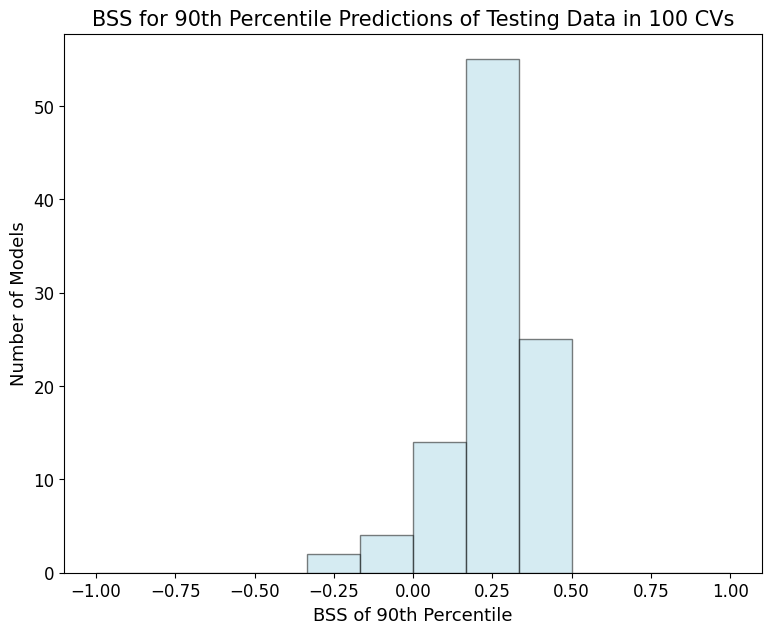

In [28]:
bins = np.linspace(-1, 1,13)
counts, edges, = np.histogram(BSS_90[:], bins=bins)

fig, (ax1) = plt.subplots(1,1, figsize=(9,7))

ax1.bar(edges[:-1], counts, width=np.diff(edges), 
        edgecolor='black', alpha=0.5, align='edge', color='lightblue')
ax1.set_xlabel('BSS of 90th Percentile',fontsize =13)
ax1.set_ylabel('Number of Models',fontsize =13)
plt.tick_params(labelsize = 12)
ax1.set_title('BSS for 90th Percentile Predictions of Testing Data in 100 CVs',fontsize =15)
plt.savefig("./images/BSS90_eur14_FCNN.png")

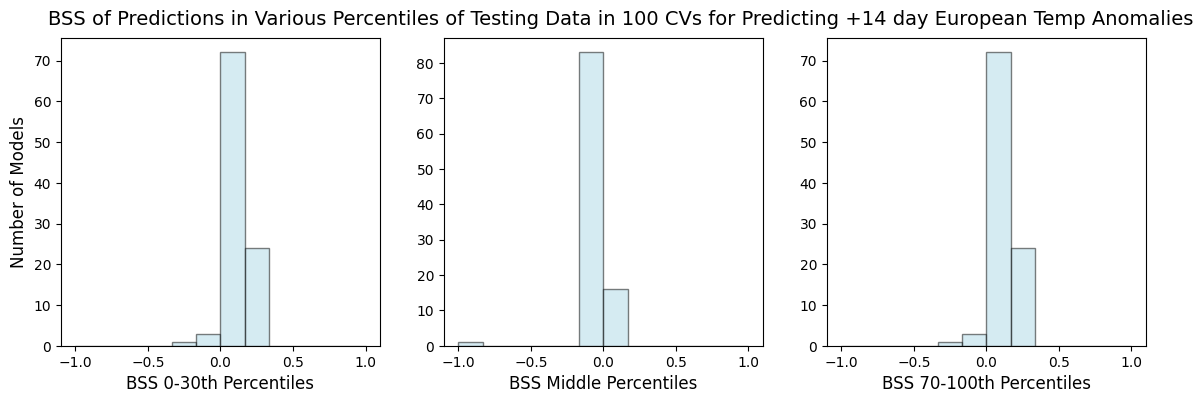

In [29]:
bins = np.linspace(-1, 1,13)
fs = 11

counts1, edges1, = np.histogram(BSS_30[:], bins=bins)
counts2, edges2, = np.histogram(BSS_avg[:], bins=bins)
counts3, edges3, = np.histogram(BSS_70[:], bins=bins)

fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(14,4))

ax1.bar(edges1[:-1], counts1, width=np.diff(edges1), 
        edgecolor='black', alpha=0.5, align='edge', color='lightblue')
ax1.set_xlabel('BSS 0-30th Percentiles', fontsize=fs+1)
ax1.set_ylabel('Number of Models', fontsize=fs+1)

ax2.bar(edges2[:-1], counts2, width=np.diff(edges2), 
        edgecolor='black', alpha=0.5, align='edge', color='lightblue')
ax2.set_xlabel('BSS Middle Percentiles', fontsize=fs+1)
#ax2.set_ylabel('Number of Models', fontsize=fs+1)

ax3.bar(edges3[:-1], counts3, width=np.diff(edges3), 
        edgecolor='black', alpha=0.5, align='edge', color='lightblue')
ax3.set_xlabel('BSS 70-100th Percentiles', fontsize=fs+1)
#ax3.set_ylabel('Number of Models', fontsize=fs+1)

plt.suptitle('BSS of Predictions in Various Percentiles of Testing Data in 100 CVs for Predicting +14 day European Temp Anomalies', fontsize=fs+3, x=0.525,y=0.95)
plt.savefig("./images/BSSpercentile_eur14_FCNN.png")

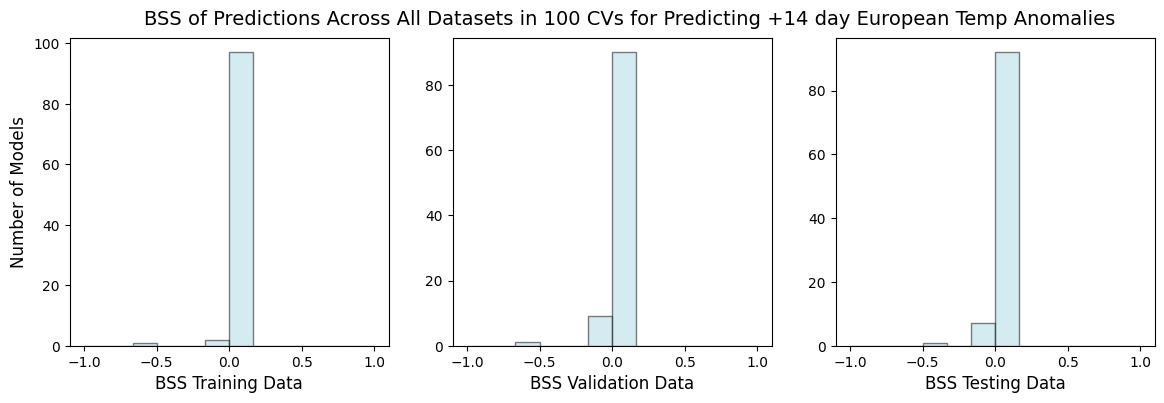

In [30]:
bins = np.linspace(-1, 1,13)
fs = 11

counts1, edges1, = np.histogram(BSS_train[:], bins=bins)
counts2, edges2, = np.histogram(BSS_val[:], bins=bins)
counts3, edges3, = np.histogram(BSS_test[:], bins=bins)

fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(14,4))

ax1.bar(edges1[:-1], counts1, width=np.diff(edges1), 
        edgecolor='black', alpha=0.5, align='edge', color='lightblue')
ax1.set_xlabel('BSS Training Data', fontsize=fs+1)
ax1.set_ylabel('Number of Models', fontsize=fs+1)

ax2.bar(edges2[:-1], counts2, width=np.diff(edges2), 
        edgecolor='black', alpha=0.5, align='edge', color='lightblue')
ax2.set_xlabel('BSS Validation Data', fontsize=fs+1)
#ax2.set_ylabel('Number of Models', fontsize=fs+1)

ax3.bar(edges3[:-1], counts3, width=np.diff(edges3), 
        edgecolor='black', alpha=0.5, align='edge', color='lightblue')
ax3.set_xlabel('BSS Testing Data', fontsize=fs+1)
#ax3.set_ylabel('Number of Models', fontsize=fs+1)

plt.suptitle('BSS of Predictions Across All Datasets in 100 CVs for Predicting +14 day European Temp Anomalies', fontsize=fs+3, x=0.525,y=0.95)
plt.savefig("./images/BSSdatasets_eur14_FCNN.png")

In [31]:
p_test = np.array(p_test)
p_test = p_test.reshape(((len(p_test),2)))

p_train = np.array(p_train)
p_train = p_train.reshape(((len(p_train),2)))

p_val= np.array(p_val)
p_val = p_val.reshape(((len(p_val),2)))

p_mid= np.array(p_mid)
p_mid = p_mid.reshape(((len(p_mid),2)))

p_30= np.array(p_30)
p_30 = p_30.reshape(((len(p_30),2)))

p_70= np.array(p_70)
p_70 = p_70.reshape(((len(p_70),2)))

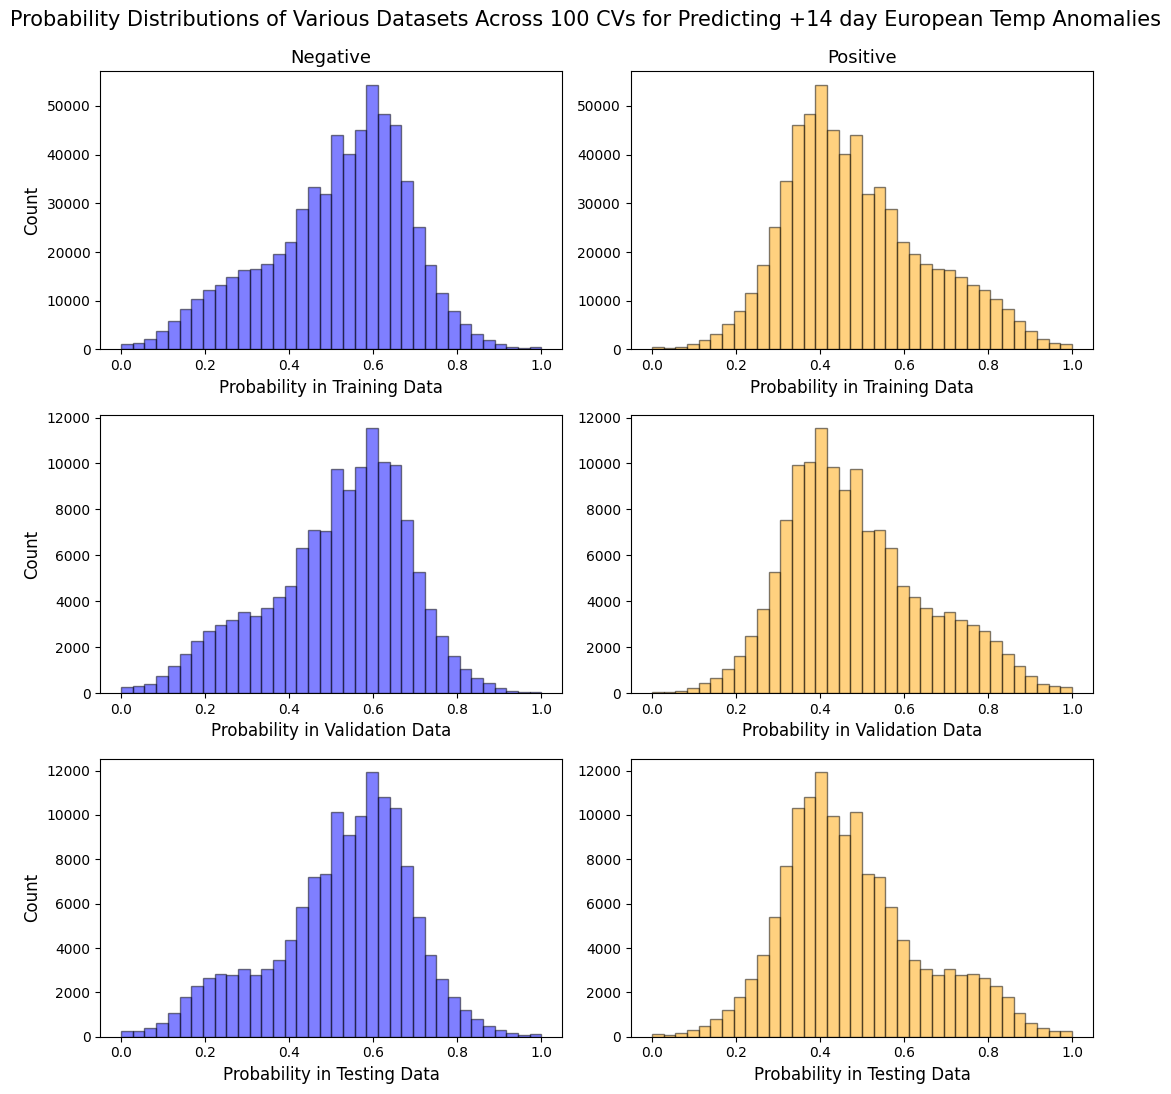

In [32]:
bins = np.linspace(0, 1, 37)  #10 bins from 0.4 to 1
fs = 11
##bin the probabilities
counts_neg_train, edges_neg_train = np.histogram(p_train[:,0], bins=bins)
counts_pos_train, edges_pos_train = np.histogram(p_train[:,1], bins=bins)

counts_neg_val, edges_neg_val = np.histogram(p_val[:,0], bins=bins)
counts_pos_val, edges_pos_val = np.histogram(p_val[:,1], bins=bins)

counts_neg_test, edges_neg_test = np.histogram(p_test[:,0], bins=bins)
counts_pos_test, edges_pos_test = np.histogram(p_test[:,1], bins=bins)


fig, axes = plt.subplots(3, 2, figsize=(11,11))
ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()

ax1.bar(edges_neg_train[:-1], counts_neg_train, width=np.diff(edges_neg_train), 
        edgecolor='black', alpha=0.5, align='edge', color='blue')
ax1.set_title('Negative', fontsize=fs+2)
ax1.set_xlabel('Probability in Training Data', fontsize=fs+1)
ax1.set_ylabel('Count', fontsize=fs+1)

ax2.bar(edges_pos_train[:-1], counts_pos_train, width=np.diff(edges_pos_train), 
        edgecolor='black', alpha=0.5, align='edge', color='orange')
ax2.set_title('Positive', fontsize=fs+2)
ax2.set_xlabel('Probability in Training Data', fontsize=fs+1)
#ax2.set_ylabel('Count')

ax3.bar(edges_neg_val[:-1], counts_neg_val, width=np.diff(edges_neg_val), 
        edgecolor='black', alpha=0.5, align='edge', color='blue')
#ax3.set_title('Negative Validation Predictions', fontsize=fs)
ax3.set_xlabel('Probability in Validation Data', fontsize=fs+1)
ax3.set_ylabel('Count', fontsize=fs+1)

ax4.bar(edges_pos_val[:-1], counts_pos_val, width=np.diff(edges_pos_val), 
        edgecolor='black', alpha=0.5, align='edge', color='orange')
#ax4.set_title('Positive Validation Predictions', fontsize=fs)
ax4.set_xlabel('Probability in Validation Data', fontsize=fs+1)
#ax4.set_ylabel('Count')

ax5.bar(edges_neg_test[:-1], counts_neg_test, width=np.diff(edges_neg_test), 
        edgecolor='black', alpha=0.5, align='edge', color='blue')
#ax5.set_title('Negative Testing Predictions', fontsize=fs)
ax5.set_xlabel('Probability in Testing Data', fontsize=fs+1)
ax5.set_ylabel('Count', fontsize=fs+1)

ax6.bar(edges_pos_test[:-1], counts_pos_test, width=np.diff(edges_pos_test), 
        edgecolor='black', alpha=0.5, align='edge', color='orange')
#ax6.set_title('Positive Testing Predictions', fontsize=fs)
ax6.set_xlabel('Probability in Testing Data', fontsize=fs+1)
#ax6.set_ylabel('Count')

plt.suptitle("Probability Distributions of Various Datasets Across 100 CVs for Predicting +14 day European Temp Anomalies", fontsize=fs+4, x=0.525,y=0.99)
plt.tight_layout()
plt.savefig("./images/probability_distrib_eur14_FCNN.png")

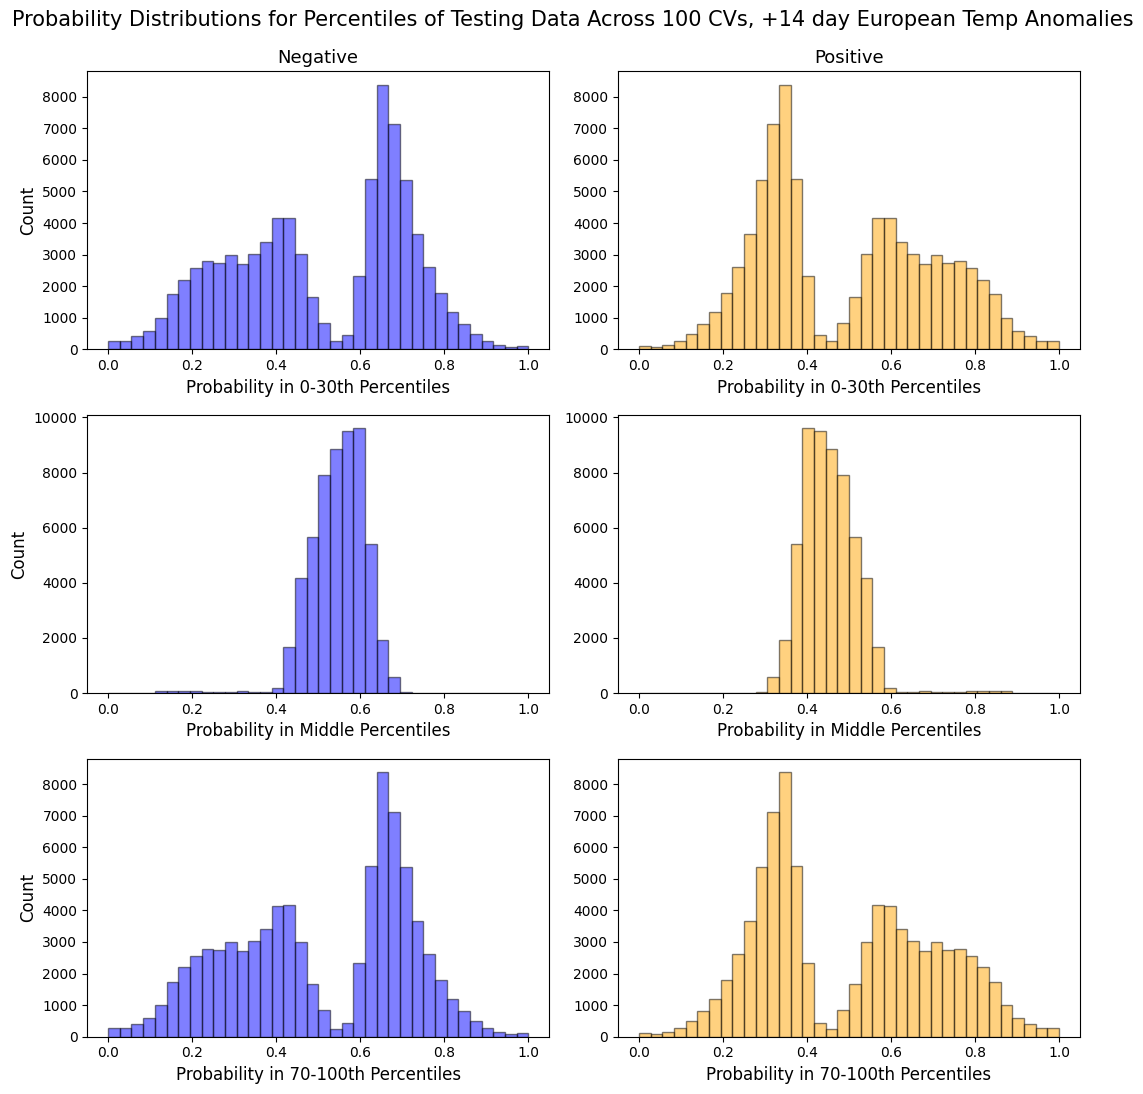

In [33]:
bins = np.linspace(0, 1, 37)  #10 bins from 0.4 to 1
fs = 11
##bin the probabilities
counts_neg_train, edges_neg_train = np.histogram(p_30[:,0], bins=bins)
counts_pos_train, edges_pos_train = np.histogram(p_30[:,1], bins=bins)

counts_neg_val, edges_neg_val = np.histogram(p_mid[:,0], bins=bins)
counts_pos_val, edges_pos_val = np.histogram(p_mid[:,1], bins=bins)

counts_neg_test, edges_neg_test = np.histogram(p_70[:,0], bins=bins)
counts_pos_test, edges_pos_test = np.histogram(p_70[:,1], bins=bins)


fig, axes = plt.subplots(3, 2, figsize=(11,11))
ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()

ax1.bar(edges_neg_train[:-1], counts_neg_train, width=np.diff(edges_neg_train), 
        edgecolor='black', alpha=0.5, align='edge', color='blue')
ax1.set_title('Negative', fontsize=fs+2)
ax1.set_xlabel('Probability in 0-30th Percentiles', fontsize=fs+1)
ax1.set_ylabel('Count', fontsize=fs+1)

ax2.bar(edges_pos_train[:-1], counts_pos_train, width=np.diff(edges_pos_train), 
        edgecolor='black', alpha=0.5, align='edge', color='orange')
ax2.set_title('Positive', fontsize=fs+2)
ax2.set_xlabel('Probability in 0-30th Percentiles', fontsize=fs+1)
#ax2.set_ylabel('Count')

ax3.bar(edges_neg_val[:-1], counts_neg_val, width=np.diff(edges_neg_val), 
        edgecolor='black', alpha=0.5, align='edge', color='blue')
#ax3.set_title('Negative Validation Predictions', fontsize=fs)
ax3.set_xlabel('Probability in Middle Percentiles', fontsize=fs+1)
ax3.set_ylabel('Count', fontsize=fs+1)

ax4.bar(edges_pos_val[:-1], counts_pos_val, width=np.diff(edges_pos_val), 
        edgecolor='black', alpha=0.5, align='edge', color='orange')
#ax4.set_title('Positive Validation Predictions', fontsize=fs)
ax4.set_xlabel('Probability in Middle Percentiles', fontsize=fs+1)
#ax4.set_ylabel('Count')

ax5.bar(edges_neg_test[:-1], counts_neg_test, width=np.diff(edges_neg_test), 
        edgecolor='black', alpha=0.5, align='edge', color='blue')
#ax5.set_title('Negative Testing Predictions', fontsize=fs)
ax5.set_xlabel('Probability in 70-100th Percentiles', fontsize=fs+1)
ax5.set_ylabel('Count', fontsize=fs+1)

ax6.bar(edges_pos_test[:-1], counts_pos_test, width=np.diff(edges_pos_test), 
        edgecolor='black', alpha=0.5, align='edge', color='orange')
#ax6.set_title('Positive Testing Predictions', fontsize=fs)
ax6.set_xlabel('Probability in 70-100th Percentiles', fontsize=fs+1)
#ax6.set_ylabel('Count')

plt.suptitle("Probability Distributions for Percentiles of Testing Data Across 100 CVs, +14 day European Temp Anomalies", fontsize=fs+4, x=0.525,y=0.99)
plt.tight_layout()
plt.savefig("./images/percentile_distrib_eur14_FCNN.png")

### Model Curves. 

### Skill Score Distributions. 

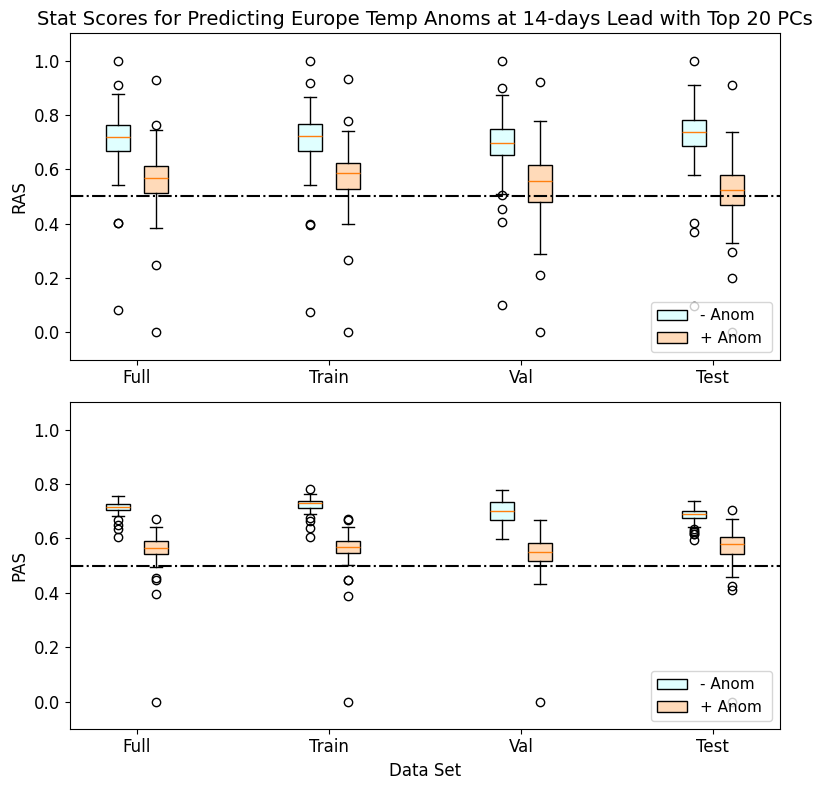

In [34]:
#plot
fig = plt.figure(figsize=(8,8))
font = 12
#loop through each member
ax2 = plt.subplot(2,1,1)
ax3 = plt.subplot(2,1,2)

ticks = ['Full', 'Train', 'Val', 'Test'] #set tick numbers for dataset
colors = ['lightcyan','peachpuff']
ind = [2, 4, 6, 8]  # the x locations for the groups
w = 0.25 #box-plot width
labels = ['- Anom', '+ Anom '] #labels of quantiles


##begin to go plot by plot ...
#each plot has a separate plot function for each lead time. In these, the plots get each quantile plotted. 
ax2.set_title("Stat Scores for Predicting Europe Temp Anoms at 14-days Lead with Top 20 PCs",fontsize = 14) 

##repeat the process
a2_0 = ax2.boxplot([Rec_all[:,0],Rec_all[:,1]], positions= [1.8,2.2], widths=w, patch_artist=True)
a2_5 = ax2.boxplot([Rec_train[:,0],Rec_train[:,1]], positions=[3.8,4.2], widths=w, patch_artist=True)
a2_10 = ax2.boxplot([Rec_val[:,0],Rec_val[:,1]], positions=[5.8,6.2], widths=w, patch_artist=True)
a2_14 = ax2.boxplot([Rec_test[:,0],Rec_test[:,1]], positions=[7.8,8.2], widths=w, patch_artist=True)
ax2.axhline(0.5, c='k', ls ='-.')
ax2.set_xticks(ind, ticks)
for bplot in (a2_0, a2_5, a2_10, a2_14):
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
for patch, label in zip(a2_0['boxes'], labels):
    patch.set_label(label)
#ax2.set_title('RAS for Temperature Region',fontsize = 14)
ax2.set_ylim(-0.1,1.1)
ax2.tick_params(axis='both', which='major', labelsize= font)
ax2.set_ylabel('RAS',fontsize = font)
#ax2.set_xlabel('Data Set',fontsize = 14)
#ax2.set_ylabel('Brier Skill Score')
ax2.legend(loc = 'lower right', fontsize = 11)
ax2.set_aspect('auto') ;

a3_0 = ax3.boxplot([Prec_all[:,0],Prec_all[:,1]], positions= [1.8,2.2], widths=w, patch_artist=True)
a3_5 = ax3.boxplot([Prec_train[:,0],Prec_train[:,1]], positions=[3.8,4.2], widths=w, patch_artist=True)
a3_10 = ax3.boxplot([Prec_val[:,0],Prec_val[:,1]], positions=[5.8,6.2], widths=w, patch_artist=True)
a3_14 = ax3.boxplot([Prec_test[:,0],Prec_test[:,1]], positions=[7.8,8.2], widths=w, patch_artist=True)
ax3.axhline(0.5, c='k', ls ='-.')
ax3.set_xticks(ind, ticks)
for bplot in (a3_0, a3_5, a3_10, a3_14):
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
for patch, label in zip(a3_0['boxes'], labels):
    patch.set_label(label)
#ax3.set_title('RAS Well')
#ax3.set_title('PAS for Temperature Region',fontsize = 14)
ax3.set_ylim(-0.1,1.1)
ax3.set_ylabel('PAS',fontsize = font)
ax3.set_xlabel('Data Set',fontsize = font)
#ax3.set_ylabel('Recall Accuracy Score',fontsize = 14)
ax3.tick_params(axis='both', which='major', labelsize= font)
ax3.legend(loc = 'lower right', fontsize = 11)
ax3.set_aspect('auto') ;

plt.tight_layout()
#plt.show()
plt.savefig("./images/EUR_StatScore_14_FCNN.png", bbox_inches='tight',dpi =150)


### Percentile ACC Plots.

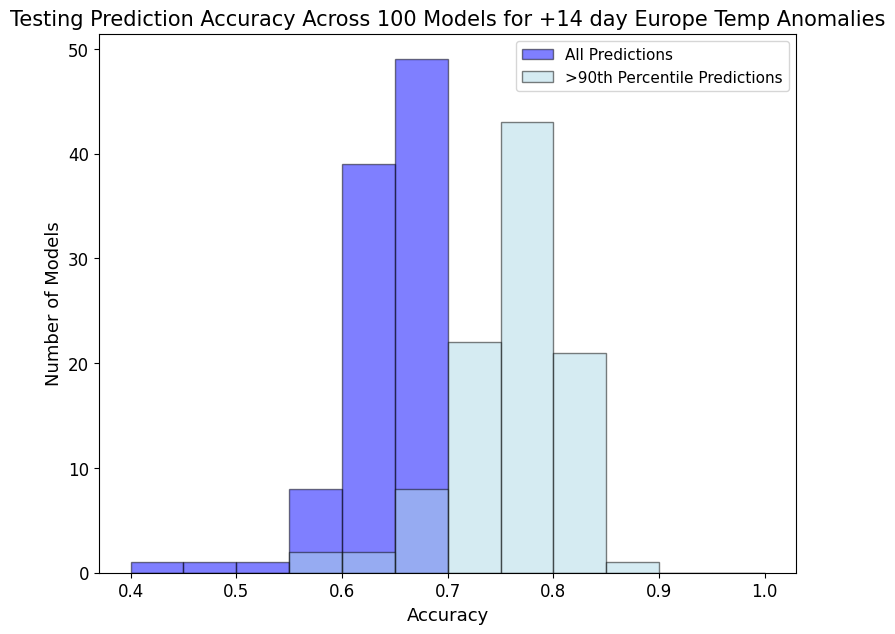

In [35]:
bins = np.linspace(0.4, 1,13)  # 10 bins from 0.4 to 1
fig = plt.figure(figsize=(9,7))
##bin the testing 90th percentile accuracy data
counts90, edges90 = np.histogram(test90_acc, bins=bins)
countsfull, edgesfull = np.histogram(fulltest_acc, bins=bins)
# Plot the full dataset
#offset = 0.02  # Adjust this value if needed for better visibility
plt.bar(edgesfull[:-1], countsfull, width=np.diff(edgesfull), 
        edgecolor='black', alpha=0.5, label='All Predictions', align='edge', color='blue')
# Plot the 90th percentile
plt.bar(edges90[:-1], counts90, width=np.diff(edges90), 
        edgecolor='black', alpha=0.5, label='>90th Percentile Predictions', align='edge', color = 'lightblue')
plt.xlabel('Accuracy', fontsize =13)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.ylabel('Number of Models', fontsize =13)
plt.legend(fontsize = 11)
plt.title('Testing Prediction Accuracy Across 100 Models for +14 day Europe Temp Anomalies', fontsize =15)
plt.savefig("./images/EUR14_ACCtesting_FCNN.png")

### Pickle out LRP stuff. 

In [36]:
##pickle out the stuff for making heat maps because I want to run it on a smaller code
##true values
pickle.dump(U_neg90_LRP, open("./LRP_stuff/U_neg90_LRP.p", 'wb'))
pickle.dump(U_pos90_LRP, open("./LRP_stuff/U_pos90_LRP.p",'wb'))
pickle.dump(EHF_neg90_LRP, open("./LRP_stuff/EHF_neg90_LRP.p", 'wb'))
pickle.dump(EHF_pos90_LRP, open("./LRP_stuff/EHF_pos90_LRP.p",'wb'))
pickle.dump(GPH_neg90_LRP, open("./LRP_stuff/GPH_neg90_LRP.p", 'wb'))
pickle.dump(GPH_pos90_LRP, open("./LRP_stuff/GPH_pos90_LRP.p",'wb'))

##false values
pickle.dump(U_Fneg90_LRP, open("./LRP_stuff/U_Fneg90_LRP.p",'wb'))
pickle.dump(U_Fpos90_LRP, open("./LRP_stuff/U_Fpos90_LRP.p",'wb'))
pickle.dump(EHF_Fneg90_LRP, open("./LRP_stuff/EHF_Fneg90_LRP.p",'wb'))
pickle.dump(EHF_Fpos90_LRP, open("./LRP_stuff/EHF_Fpos90_LRP.p",'wb'))
pickle.dump(GPH_Fneg90_LRP, open("./LRP_stuff/GPH_Fneg90_LRP.p",'wb'))
pickle.dump(GPH_Fpos90_LRP, open("./LRP_stuff/GPH_Fpos90_LRP.p",'wb'))

##for composites
pickle.dump(U_comp_pos, open("./LRP_stuff/U_comp_pos.p",'wb'))
pickle.dump(U_comp_Fpos, open("./LRP_stuff/U_compFpos.p",'wb'))
pickle.dump(U_comp_neg, open("./LRP_stuff/U_comp_neg.p",'wb'))
pickle.dump(U_comp_Fneg, open("./LRP_stuff/U_compFneg.p",'wb'))

pickle.dump(EHF_comp_pos, open("./LRP_stuff/EHF_comp_pos.p",'wb'))
pickle.dump(EHF_comp_Fpos, open("./LRP_stuff/EHF_compFpos.p",'wb'))
pickle.dump(EHF_comp_neg, open("./LRP_stuff/EHF_comp_neg.p",'wb'))
pickle.dump(EHF_comp_Fneg, open("./LRP_stuff/EHF_compFneg.p",'wb'))

pickle.dump(GPH_comp_pos, open("./LRP_stuff/GPH_comp_pos.p",'wb'))
pickle.dump(GPH_comp_Fpos, open("./LRP_stuff/GPH_compFpos.p",'wb'))
pickle.dump(GPH_comp_neg, open("./LRP_stuff/GPH_comp_neg.p",'wb'))
pickle.dump(GPH_comp_Fneg, open("./LRP_stuff/GPH_compFneg.p",'wb'))
